# Postprocessing

In [85]:
import xarray as xr 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from mpl_toolkits.mplot3d import Axes3D  
import glob
import seaborn as sns 
import os
from matplotlib.colors import to_hex
from matplotlib.lines import Line2D
from pathlib import Path
import sys

project_root = Path.cwd().parents[0]
sys.path.append(str(project_root))

from utils.plotting import create_figure, palette, colorwheel, customize_axis, get_figure_dimensions
from utils.bathymetry import generate_bathymetry
from utils.config import load_config, default_params
from utils.io import read_raw_output
from utils.grid import prepare_dsH, interp_ds

print(colorwheel)

['#000000', '#009e73', '#d55e00', '#0072b2', '#555555', '#aaaaaa']


In [2]:
figpath = "../figures/"

#option to not run all processing again, but rather load preprocessed data
load_preprocessed = True

# option to  save processed data to file for faster loading later
save_processed = True

## A4 analysis

In [3]:
data = xr.open_dataset("../output/processed/A4/canadian_2750_100000_estimates.nc")
data

<xarray.Dataset>
Dimensions:    (time: 1895, R: 75)
Coordinates:
  * time       (time) datetime64[ns] 2014-01-01T12:00:00 ... 2019-03-10T12:00:00
  * R          (R) float64 2e-05 4e-05 6e-05 8e-05 ... 0.00146 0.00148 0.0015
Data variables:
    circ_u     (time) float64 ...
    circ_ub    (time) float64 ...
    circ_us    (time) float64 ...
    circ_tau   (time) float64 ...
    estimates  (R, time) float64 ...
    r_ubar     (R) float64 ...
    r          (R) float64 ...
Attributes:
    contour_file:  canadian_2750_100000.nc

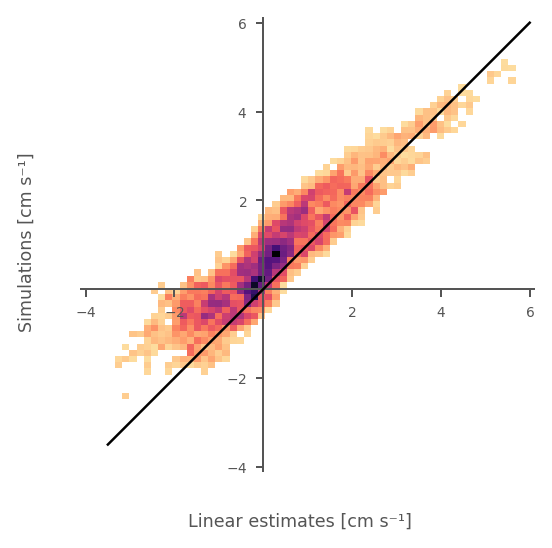

In [4]:
est_filepath = "../output/processed/A4/"

# number of time steps
nt = 1895

# Define the basins and depths to be analyzed
basins = np.array(["canadian", "eurasian", "greenland", "norwegian"])
depths = np.array([2500, 2750, 3000, 3250, 3500, 3750])

# Initialize arrays to store circulation estimates and bottom circulation for each basin and depth
circulation_estimated = np.zeros((len(basins), len(depths), nt))
circulation_bottom = np.zeros((len(basins), len(depths), nt))

# Create an array of NaNs to handle missing data
tsnan = np.zeros(nt) * np.nan

# Loop through each basin and depth to extract circulation data
for i, basin in enumerate(basins):
    for j, depth in enumerate(depths):
        cfile = est_filepath + f"{basin}_{depth}_100000_estimates.nc"
        
        if os.path.exists(cfile):
            data = xr.open_dataset(cfile)
            
            # Select the R value corresponding to the maximum correlation
            R = data.r.idxmax()
            ds = data.sel(R=R)
            
            # Store the estimated and bottom circulation values
            circulation_estimated[i, j, :] = ds.estimates.values
            circulation_bottom[i, j, :] = ds.circ_ub.values
        else:
            # Handle missing data by assigning NaN values
            circulation_estimated[i, j, :] = tsnan
            circulation_bottom[i, j, :] = tsnan

# Create a histogram plot to compare the distribution of estimated vs. simulated circulation
#fig_hist_est, ax = plt.subplots(constrained_layout=True, figsize=(set_size(width)[0], set_size(width)[0]))
fig, ax = create_figure( "single", aspect_ratio=1)

# Flatten the arrays and convert to the appropriate units (cm/s)
x = circulation_estimated.flatten() * 1e2
y = circulation_bottom.flatten() * 1e2

# Remove NaN values from the flattened arrays
x = x[np.isfinite(x)]
y = y[np.isfinite(y)]

# Plot the joint histogram of estimated and simulated circulation values
sns.histplot(x=x, y=y, 
             bins=75, 
             pthresh=.1, 
             cmap="magma_r", 
             ax=ax,
             zorder=-2
             )

# Overlay KDE plot with white contours
# sns.kdeplot(x=x, y=y, 
#             levels=7, 
#             color="w", 
#             linewidths=1, 
#             ax=ax,
#             zorder=-1
#             )

# Plot a reference line (y=x) to help assess the agreement between estimates and simulations
ax.plot((-3.5, 6), (-3.5, 6), color=palette["text"], zorder=12)

# Set the aspect ratio of the plot to be equal
ax.set_aspect('equal')

customize_axis(ax)

# Define the tick positions for the x and y axes
ax.set_yticks([-4, -2, 2, 4, 6])
ax.set_xticks([-4, -2, 2, 4, 6])

ax.set_xlim([-4.1, 6.1])
ax.set_ylim([-4.1, 6.1])

# Add labels to the figure
fig.supxlabel('Linear estimates [cm s⁻¹]', fontsize=7)
fig.supylabel('Simulations [cm s⁻¹]', fontsize=7)

fig.savefig(figpath + "A4_histogram.pdf")

## Read in base cases

In [5]:
params_L = load_config("../configs/baseline_forcing/long.json")
params_S = load_config("../configs/baseline_forcing/short.json")

ds_L = read_raw_output(params_L)
ds_S = read_raw_output(params_S)

Loading configuration from ../configs/baseline_forcing/long.json
Loading configuration from ../configs/baseline_forcing/short.json


In [6]:
ds_L

<xarray.Dataset>
Dimensions:    (xC: 90, yF: 91, xF: 90, yC: 90, time: 3073)
Coordinates:
  * xC         (xC) float64 500.0 1.5e+03 2.5e+03 ... 8.75e+04 8.85e+04 8.95e+04
  * yF         (yF) float64 0.0 1e+03 2e+03 3e+03 ... 8.8e+04 8.9e+04 9e+04
  * xF         (xF) float64 0.0 1e+03 2e+03 3e+03 ... 8.7e+04 8.8e+04 8.9e+04
  * yC         (yC) float64 500.0 1.5e+03 2.5e+03 ... 8.75e+04 8.85e+04 8.95e+04
  * time       (time) timedelta64[ns] 0 days 00:00:00 ... 384 days 00:00:00
Data variables:
    v          (time, yF, xC) float64 ...
    duvhdy     (time, yF, xF) float64 ...
    zetau      (time, yF, xF) float64 ...
    zetav      (time, yF, xF) float64 ...
    u          (time, yC, xF) float64 ...
    zeta       (time, yF, xF) float64 ...
    detadx     (time, yC, xF) float64 ...
    h          (time, yC, xC) float64 ...
    bath       (yC, xC) float64 100.1 100.1 100.1 100.1 ... 899.9 899.9 899.9
    forcing_x  (time, yC, xC) float64 3.067e-07 3.067e-07 ... 3.067e-07
    forcing_y  (time, yC, xC) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
Attributes:
    time averaging stride:  Output was time averaged with a stride of 1 itera...
    interval:               10800.0
    time_averaging_window:  10800.0
    time_averaging_stride:  1
    Oceananigans:           This file was generated using Oceananigans v0.95.5
    Julia:                  This file was generated using Julia Version 1.9.4...
    output time interval:   Output was saved every 3 hours.
    date:                   This file was generated on 2025-08-28T17:12:19.604.
    time averaging window:  Output was time averaged with a window size of 3 ...
    schedule:               TimeInterval

### Bathymetry

In [7]:
from utils.plotting import plot_bathymetry, add_bathymetry_contours

In [8]:
# select target depths for contours
H_targets = ds_L.bath.mean("xC").values

# focus depth contour will be in the middle of the slope
focus_j = 45

In [9]:
X, Y, h = generate_bathymetry(default_params, full=True)

# m to km
X /= 1e3
Y /= 1e3

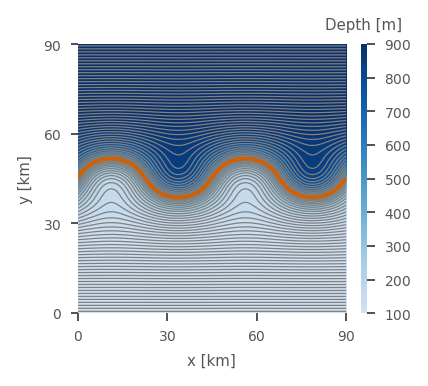

In [10]:
#fig, ax = create_figure("double", aspect_ratio=0.9)
(fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=0.9)
fig, ax = plt.subplots(figsize=(fig_width_in/2, fig_height_in))

# remove spines, keeping ticks
ax.spines['bottom'].set_visible(False)
ax.spines['left'].set_visible(False)

img = plot_bathymetry(ax, X, Y, h)
cb = fig.colorbar(img, ax=ax, 
             fraction=0.02325, 
             aspect=40,
             )
cb.outline.set_visible(False)

# sett the title of the colorbar
cb.ax.set_title("Depth [m]", fontsize=6)

ax.set_aspect("equal", 
              #adjustable="box"
              )

# thin grey contours
add_bathymetry_contours(ax, X, Y, h, H_targets, color='gray', linewidth=0.5)

# highlight one contour
add_bathymetry_contours(ax, X, Y, h, [H_targets[focus_j]], color=colorwheel[2], linewidth=1.5)

#fig.set_layout_engine("constrained")   
#fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, wspace=0.02, hspace=0.02)


fig.tight_layout()
fig.savefig(figpath+"2dbath.pdf")

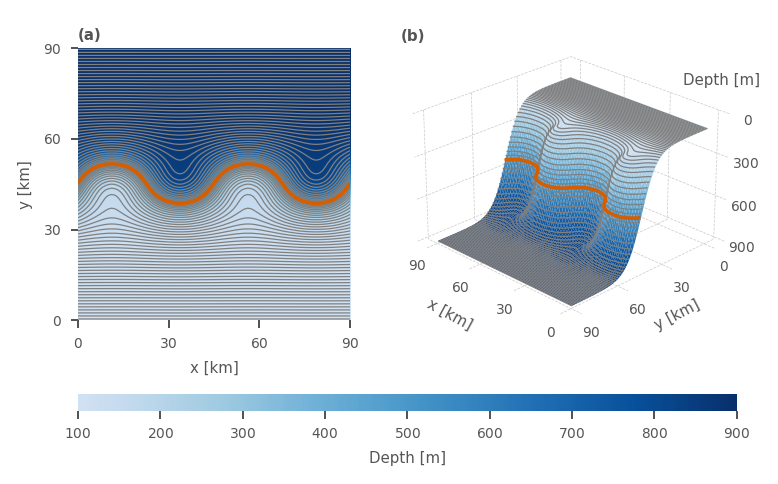

In [11]:
# --- Figure & layout: 2 panels (2D + 3D) ------------------------------------
(fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=0.6)

fig = plt.figure(figsize=(fig_width_in, fig_height_in))
gs = fig.add_gridspec(
    2, 2,
    height_ratios=[20, 1],   # big row for plots, small row for cbar
    width_ratios=[0.8, 1],
    hspace=0.25,
    wspace=0.15,
)

ax2d   = fig.add_subplot(gs[0, 0])
ax3d   = fig.add_subplot(gs[0, 1], projection="3d")
cbar_ax = fig.add_subplot(gs[1, :])   # spans both columns

# --- 2D bathymetry panel (left) ---------------------------------------------
# remove spines, keeping ticks
ax2d.spines['bottom'].set_visible(False)
ax2d.spines['left'].set_visible(False)

img = plot_bathymetry(ax2d, X, Y, h)

ax2d.set_aspect("equal")
add_bathymetry_contours(ax2d, X, Y, h, H_targets, color='gray', linewidth=0.5)
add_bathymetry_contours(ax2d, X, Y, h, [H_targets[focus_j]], color=colorwheel[2], linewidth=1.5)

ax2d.set_xlabel("x [km]")    # adjust to your labels
ax2d.set_ylabel("y [km]")

# --- 3D bathymetry panel (right) --------------------------------------------
#from matplotlib.colors import LightSource

# Make a shaded RGB array based on depth
# ls = LightSource(azdeg=0, altdeg=45)
# rgb = ls.shade(
#     h,                    # or -h, depending on how you want illumination
#     cmap=img.cmap,
#     vert_exag=0.65,       # match your z exaggeration-ish
#     blend_mode='soft'
# )

surf = ax3d.plot_surface(
    X, Y-0.5, h,
    cmap=img.cmap,
    norm=img.norm,
    rstride=1, cstride=1,
    linewidth=0,
    edgecolor='none',
    antialiased=True,
    shade=False,     # avoids faint geometrical artifacts
    alpha=1.0,
)

# Highlight the same focus contour as in 2D
# ax3d.contour(
#     X, Y, h,
#     levels=[H_targets[focus_j]],
#     colors=colorwheel[2],
#     linewidths=1.5,
#     zorder=30
# )

ax3d.contour(
    X, Y, h,
    levels=H_targets,
    colors='gray',
    linewidths=0.5,
)

# ax3d.contour(
#     X, Y, h,
#     levels=H_targets[[focus_j,-1]],
#     colors=colorwheel[2],
#     linewidths=1.5,
# )

ax3d.contour(
    X, Y, h,
    levels=H_targets[[focus_j, -1]],
    colors=[colorwheel[2], 'none'],   # real line + invisible dummy line
    linewidths=[1.5, 0]
)


# Make depth increase downward
ax3d.invert_zaxis()

# Camera angle (tweak as you like)
ax3d.view_init(elev=25, azim=135)

# Axis labels
# ax3d.set_xlabel("x [km]")
# ax3d.set_ylabel("y [km]")
# ax3d.set_zlabel("Depth [m]")
ax3d.text3D(30, 150, 900, "x [km]", fontsize=6, zdir='x')
ax3d.text3D(-40, 80, 900, "y [km]", fontsize=6, zdir='y')
ax3d.text2D(0.85, 0.8, "Depth [m]", fontsize=6, transform=ax3d.transAxes)


# Reduce padding for x and y tick labels
ax3d.tick_params(axis='x', pad=-4)
ax3d.tick_params(axis='y', pad=-4)
ax3d.tick_params(axis='z', pad=-4)


# Make x and y equal, z 1/10 of that
ax3d.set_box_aspect((1, 1, 0.65))

# Optional: clean up 3D look a bit
ax3d.xaxis.pane.set_alpha(0.0)
ax3d.yaxis.pane.set_alpha(0.0)
ax3d.zaxis.pane.set_alpha(0.0)
for axis in [ax3d.xaxis, ax3d.yaxis, ax3d.zaxis]:
    axis._axinfo["grid"]["linewidth"] = 0.3
    

ax3d.set_xticks([0,30,60,90])
ax3d.set_yticks([0,30,60,90])
ax3d.set_zticks([0,300,600,900])

# --- Horizontal shared colorbar (own axis in the mosaic) --------------------
cb = fig.colorbar(
    img,
    cax=cbar_ax,
    orientation="horizontal",
)
cb.outline.set_visible(False)
cb.ax.set_xlabel("Depth [m]", fontsize=6)



# remove spines
for axis in (ax3d.xaxis, ax3d.yaxis, ax3d.zaxis):
    axis.line.set_visible(False)              # turn off main spine line
    axis._axinfo['tick']['inward_factor'] = 0
    axis._axinfo['tick']['outward_factor'] = 0


# add labels (a) and (b)
ax2d.text(0, 1.03, "(a)", transform=ax2d.transAxes,fontweight='bold')
ax3d.text2D(0, 0.931,"(b)", transform=ax3d.transAxes, fontweight='bold')

# --- Layout & export --------------------------------------------------------
#fig.tight_layout()
fig.savefig(figpath + "bath_2d3d.pdf")


## Analysis on depth conturs

In [12]:
if load_preprocessed:
    dsH_L = xr.open_dataset("../output/processed/baseline_forcing/dsH_L.nc")
    dsH_S = xr.open_dataset("../output/processed/baseline_forcing/dsH_S.nc")

else:    
    # interpolate dataset onto the selected depth-contours
    dsH_L = prepare_dsH(ds_L, params_L, H_targets)
    dsH_S = prepare_dsH(ds_S, params_S, H_targets)
    
    if save_processed:
        os.makedirs("../output/processed/baseline_forcing/", exist_ok=True)
        dsH_L.to_netcdf("../output/processed/baseline_forcing/dsH_L.nc")
        dsH_S.to_netcdf("../output/processed/baseline_forcing/dsH_S.nc")    

dsH_L

<xarray.Dataset>
Dimensions:    (time: 3073, j: 90, i: 120)
Coordinates:
  * time       (time) timedelta64[ns] 0 days 00:00:00 ... 384 days 00:00:00
    x          (j, i) float64 ...
    y          (j, i) float64 ...
  * i          (i) int32 0 1 2 3 4 5 6 7 8 ... 112 113 114 115 116 117 118 119
  * j          (j) int32 0 1 2 3 4 5 6 7 8 9 ... 80 81 82 83 84 85 86 87 88 89
Data variables: (12/19)
    v          (time, j, i) float64 ...
    duvhdy     (time, j, i) float64 ...
    zetau      (time, j, i) float64 ...
    zetav      (time, j, i) float64 ...
    u          (time, j, i) float64 ...
    zeta       (time, j, i) float64 ...
    ...         ...
    zetaflux   (time, j, i) float64 ...
    un         (time, j, i) float64 ...
    dtx        (j, i) float64 ...
    dty        (j, i) float64 ...
    dl         (j, i) float64 ...
    depth      (j) float64 ...
Attributes:
    time averaging stride:  Output was time averaged with a stride of 1 itera...
    interval:               10800.0
    time_averaging_window:  10800.0
    time_averaging_stride:  1
    Oceananigans:           This file was generated using Oceananigans v0.95.5
    Julia:                  This file was generated using Julia Version 1.9.4...
    output time interval:   Output was saved every 3 hours.
    date:                   This file was generated on 2025-08-28T17:12:19.604.
    time averaging window:  Output was time averaged with a window size of 3 ...
    schedule:               TimeInterval

In [13]:
def mean_onH(dsH, variable):
    """Compute mean of variable along depth-following contours (H-contours)."""
    return (dsH[variable] * dsH.dl).sum("i") / dsH.dl.sum("i")

def calculate_analytical_estimates_xr(
    ds: xr.Dataset,
    forcing_vars: list[str],
    params: dict,
) -> xr.DataArray:
    """
    y(t_j) = ∫_0^{t_j} exp[-(R/H(j)) * (t_j - τ)] * F(τ, j) dτ
    One-pass recurrence (left Riemann per step) with constant Δt = params["outputtime"].
    Recurrence: y_i = decay * y_{i-1} + alpha * F_{i-1},
    where decay = exp(-k*Δt), alpha = (1 - decay)/k, k = R/H(j).
    """
    R = float(params["R"])
    dt = float(params["outputtime"]) 

    H = ds["depth"]  
    
    # Sum forcing fields (must have dims include "time" and "j")
    F = sum(ds[v] for v in forcing_vars)

    t = ds["time"]
    nT = t.sizes["time"]
    if nT == 0:
        raise ValueError("Empty time axis.")
    if nT == 1:
        return xr.zeros_like(F)

    # k(j) = R/H(j), broadcast over all non-time dims of F
    k = (R / H).broadcast_like(F.isel(time=0))

    # Precompute coefficients (constant in time)
    decay = np.exp(-k * dt)
    # Safe alpha for k≈0: limit -> dt
    alpha = xr.where(np.abs(k) > 0, (1.0 - decay) / k, dt)

    # build y 
    y0 = xr.zeros_like(F.isel(time=0, drop=True))
    ys = [y0]
    for i in range(1, nT):
        Fi_1 = F.isel(time=i - 1, drop=True)  # drop time here too
        y_next = decay * ys[-1] + alpha * Fi_1
        ys.append(y_next)
    y = xr.concat(ys, dim="time").assign_coords(time=t) / H

    return y

In [14]:
for dsH, params in zip([dsH_L, dsH_S], [params_L, params_S]):
    # dsH["zetaflux"] = dsH.zetaflux * dsH.h
    # dsH["unh"] = dsH.un * dsH.h
    
    # diagnose circulation
    dsH["circulation"] = mean_onH(dsH, variable="ui")
    
    # calculate momentum terms
    dsH["BS"] = -dsH.circulation*params["R"]
    dsH["TFS"] = dsH.circulation*0
    dsH["RVF"] = mean_onH(dsH, variable="zetaflux") * dsH.depth
    #dsH["PVF"] = mean_onH(dsH, variable="unh") * params["f"] 
    dsH["SS"] = mean_onH(dsH, variable="forcing_i") 
    
    # circulation estimates
    dsH["linear_estimate"] = calculate_analytical_estimates_xr(dsH, ["SS"], params)
    dsH["nonlinear_estimate"] = calculate_analytical_estimates_xr(dsH, ["SS", "RVF"], params)

In [15]:
# We will focus on 128 days of simulations
focus_time_start_L = -(128+64)*8
focus_time_stop_L = -64*8

focus_time_start_S = -(128+8)*8
focus_time_stop_S = -8*8

# For other analyses, focus on the spesified time interval
dsH_L= dsH_L.isel(time=slice(focus_time_start_L,focus_time_stop_L))
dsH_S = dsH_S.isel(time=slice(focus_time_start_S,focus_time_stop_S))

#adjust time index so that t=0 is the beginning of the focus period
t0_L = dsH_L.time.isel(time=0)
t0_S = dsH_S.time.isel(time=0)


dsH_L["time"] = dsH_L.time - t0_L
dsH_S["time"] = dsH_S.time - t0_S

### Scatterplots

In [16]:
from utils.plotting import plot_scatter

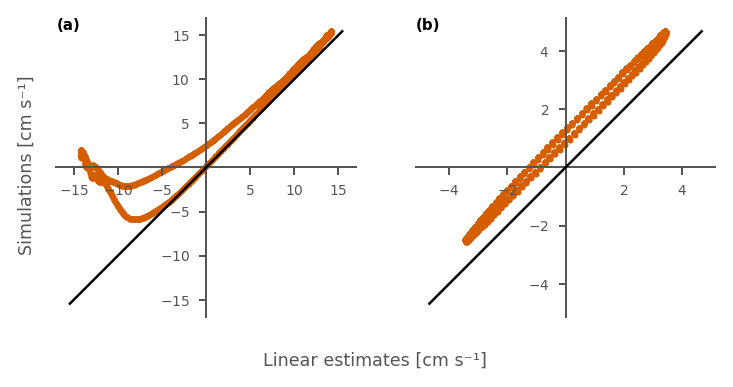

In [17]:
xL = dsH_L.isel(j=focus_j).linear_estimate*1e2
yL = dsH_L.isel(j=focus_j).circulation*1e2

fig, [axL,axS] = create_figure(
    "double", ncols=2
    #"single", aspect_ratio=1.8, nrows=2
    )
plot_scatter(axL, xL, yL, s=2)


xS = dsH_S.isel(j=focus_j).linear_estimate*1e2
yS = dsH_S.isel(j=focus_j).circulation*1e2

plot_scatter(axS, xS, yS, s=2)

fig.supxlabel('Linear estimates [cm s⁻¹]', 
              x=0.5, y=0.1, 
              fontsize=7
              )
fig.supylabel('Simulations [cm s⁻¹]', 
              x=0.08, y=0.5, 
              fontsize=7
              )


ticksL = [-15, -10, -5, 5, 10, 15]
axL.set_yticks(ticksL)
axL.set_xticks(ticksL)

ticksS = [-4, -2, 2, 4]
axS.set_yticks(ticksS)
axS.set_xticks(ticksS)

# add text annotation with subpanel label (a) and (b)
axL.text(0, 1, "(a)", color="black", 
         transform=axL.transAxes, 
         verticalalignment='top',
         fontweight='bold'
         )
axS.text(0, 1, "(b)", color="black",
         transform=axS.transAxes, 
         verticalalignment='top',
         fontweight='bold'
         )

#fig.set_constrained_layout(True)
fig.savefig(figpath+"scatterplots.pdf")

### Timeseries

In [18]:
from utils.plotting import plot_circulation_timeseries

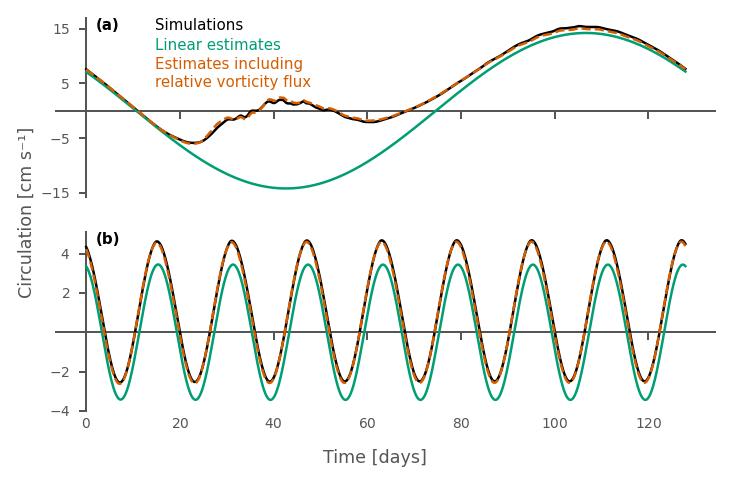

In [19]:
tsL = dsH_L.isel(j=focus_j)
tsS = dsH_S.isel(j=focus_j)

fig, [axt,axb] = create_figure("double", nrows=2, 
                               sharex =True
                               )

plot_circulation_timeseries(axt, tsL)
plot_circulation_timeseries(axb, tsS)

fig.supxlabel('Time [days]', 
              x=0.5, y=-0, 
              fontsize=7
              )
fig.supylabel('Circulation [cm s⁻¹]', 
              x=0.08, y=0.5, 
              fontsize=7
              )

axt.set_yticks([-15, -5, 5, 15])
axb.set_yticks([-4, -2, 2, 4])

# Shift x-axis tick labels downward
for label in axb.get_xticklabels():
    label.set_y(label.get_position()[1] - 3.5)
    
# add labels (a) and (b)
axt.text(0.06, 1, "(a)", color="black",
         transform=axt.transAxes, 
         verticalalignment='top',       
         fontweight='bold'
         )
axb.text(0.06, 1, "(b)", color="black",
         transform=axb.transAxes, 
         verticalalignment='top',       
         fontweight='bold'
         )

# create legend for axt outside plot
# axt.legend(
#     loc="upper left", 
#     #ncols=2,
#     fontsize=6,
#     bbox_to_anchor=(0.2, 1.1),  # shift legend outside
#     borderaxespad=0,           # tighter to plot
#     frameon=False,              # no border
# )

labels = ["Simulations", "Linear estimates", "Estimates including\nrelative vorticity flux"]
y_start = 1
line_height = 0.1  # adjust this once
y = y_start
for label, color in zip(labels, colorwheel):
    axt.text(
        0.15, y,
        label,
        color=color,
        #fontweight="bold",
        #fontsize=5,
        transform=axt.transAxes,
        ha="left", va="top"
    )
    n_lines = label.count("\n") + 1
    y -= n_lines * line_height + 0.01  # small gap between entries

fig.savefig(figpath+"timeseries_circulation.pdf")

### Momentum diagrams

In [20]:
ystart = 20
ystop = 70

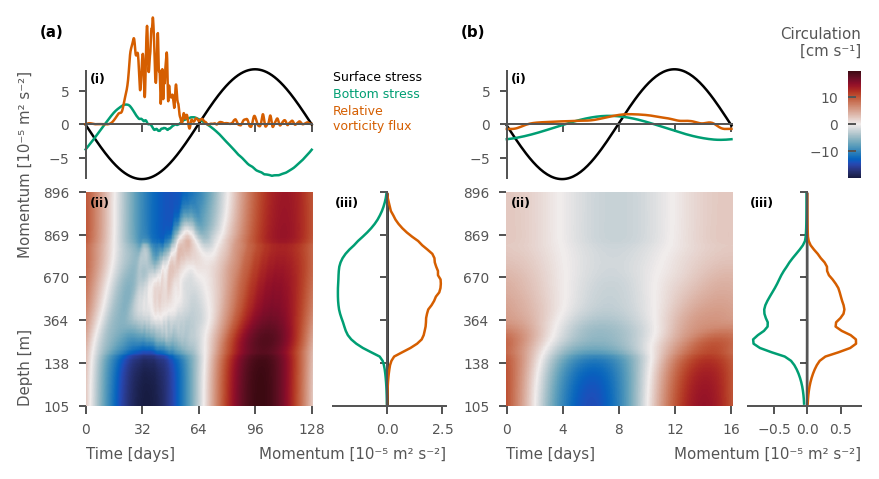

In [21]:
# --- Figure & layout ---------------------------------------------------------
(fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=0.53)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

axd = fig.subplot_mosaic(
    [
        ["ymean_a", "legend_a", "ymean_b", "legend_b"],
        ["circ_a",  "tmean_a",  "circ_b",  "tmean_b"],
    ],
    gridspec_kw=dict(
        height_ratios=[2, 4],
        width_ratios=[4, 2, 4, 2],
    ),
)

# Share axes (avoid redundant ticks/labels)
axd["ymean_a"].sharey(axd["ymean_b"])
for sub in ("a", "b"):
    axd[f"tmean_{sub}"].sharey(axd[f"circ_{sub}"])
    axd[f"ymean_{sub}"].sharex(axd[f"circ_{sub}"])

# Light axis cosmetics + remove redundant tick labels on shared axes
for sub in ("a", "b"):
    customize_axis(axd[f"tmean_{sub}"], yzero=False)
    customize_axis(axd[f"ymean_{sub}"])
    customize_axis(axd[f"legend_{sub}"], yzero=False)

    axd[f"tmean_{sub}"].tick_params(labelleft=False)  # shared y with circ_*
    axd[f"ymean_{sub}"].tick_params(labelbottom=False)  # shared x with circ_*
    
    # remove spines, keeping ticks
    axd[f"circ_{sub}"].spines['bottom'].set_visible(False)
    axd[f"circ_{sub}"].spines['left'].set_visible(False)

# Constrained layout paddings (set once)
fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, wspace=0.02, hspace=0.02)


# --- LEFT PANEL (LONG) -------------------------------------------------------
# Data & grids
tdays_L  = dsH_L.time / np.timedelta64(1, "D")
equivY_L = ds_L.isel(yC=slice(ystart, ystop)).yC / 1e3

# Color scale based on long run (you can also use both panels for vlim if desired)
vlim = np.max(np.abs(dsH_L.isel(j=slice(ystart, ystop)).circulation * 1e2))

# Half-cell padding for imshow to match pcolormesh domain behavior
dt_L = np.diff(tdays_L).mean()
dy_L = np.diff(equivY_L).mean()

cm_a = axd["circ_a"].imshow(
    dsH_L.isel(j=slice(ystart, ystop)).circulation.T * 1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_L[0] - dt_L/2, tdays_L[-1] + dt_L,
            equivY_L[0] - dy_L/2, equivY_L[-1] + dy_L/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# Optional for crisp PDF size: 
cm_a.set_rasterized(True)

# Y ticks & labels (equivalent-y line under depth)
axd["circ_a"].set_yticks(np.arange(20, 71, 10))
axd["circ_a"].set_yticklabels([f"{h:.0f}" for  h in (H_targets[ystart:ystop+1:10])])
axd["circ_a"].set_ylabel('Depth [m]', loc='bottom')
# axd["circ_a"].set_yticklabels([f"{h:.0f}\n/ {i*10+ystart}"
#                                for i, h in enumerate(H_targets[ystart:ystop+1:10])])
# axd["circ_a"].set_ylabel('Depth [m]\n/ Equivalent y [km]')
axd["circ_a"].set_xlabel('Time [days]', loc="left")
axd["circ_a"].set_xticks(np.arange(0, 129, 32))

# Lines for time-mean (tmean_a) and y-slice time series (ymean_a)
for i, term in enumerate(["SS", "BS", "RVF"]):
    # time-mean across the selected j-range
    tmean_L = dsH_L[term].isel(j=slice(ystart, ystop)).mean("time") * 1e5
    axd["tmean_a"].plot(tmean_L, equivY_L, color=colorwheel[i])

    # one y-profile time series (here j=45)
    for j, ls in zip([45], ["-"]):
        yval_L = dsH_L[term].sel(j=j) *1e5
        axd["ymean_a"].plot(tdays_L, yval_L, color=colorwheel[i], ls=ls, clip_on=False)

    # stash labels for legend (in legend_a axis)
    axd["legend_a"].plot([None, None], [None, None], label=term, color=colorwheel[i])

# Legend (in its own axis)
axd["legend_a"].axis("off")
# axd["legend_a"].legend(
#     ["Surface\nstress", "Bottom\nstress", "Relative\nvorticity\nflux"],
#     loc="upper left", fontsize=5, frameon=False, bbox_to_anchor=(0, 1.3),
# )
labels = ["Surface stress", "Bottom stress", "Relative\nvorticity flux"]
y_start = 1
line_height = 0.15  # adjust this once
y = y_start
for label, color in zip(labels, colorwheel):
    axd["legend_a"].text(
        0.0, y,
        label,
        color=color,
        fontsize=5,
        transform=axd["legend_a"].transAxes,
        ha="left", va="top"
    )
    n_lines = label.count("\n") + 1
    y -= n_lines * line_height + 0.01  # small gap between entries


# Axis labels for side panels
axd["ymean_a"].set_ylabel('Momentum [10⁻⁵ m² s⁻²]', loc='top')
axd["tmean_a"].set_xlabel('Momentum [10⁻⁵ m² s⁻²]', loc='right')


# --- RIGHT PANEL (SHORT) -----------------------------------------------------
# Slice and re-zero time for short run
dsH_Sp = dsH_S.isel(time=slice(-16*8-1, None), j=slice(ystart, ystop)).copy()
dsH_Sp["time"] = dsH_Sp["time"] - dsH_Sp["time"].isel(time=0)

tdays_S  = dsH_Sp.time / np.timedelta64(1, "D")
equivY_S = ds_S.isel(yC=slice(ystart, ystop)).yC / 1e3

# Match cell padding to short run’s grid (don’t reuse dt/dy from the left)
dt_S = np.diff(tdays_S).mean()
dy_S = np.diff(equivY_S).mean()

cm_b = axd["circ_b"].imshow(
    dsH_Sp.circulation.T * 1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_S[0] - dt_S/2, tdays_S[-1] + dt_S/2,
            equivY_S[0] - dy_S/2, equivY_S[-1] + dy_S/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# Optional: 
cm_b.set_rasterized(True)

# Y ticks (match left panel)
axd["circ_b"].set_yticks(np.arange(20, 71, 10))
axd["circ_b"].set_yticklabels([f"{h:.0f}" for  h in (H_targets[ystart:ystop+1:10])])
# axd["circ_b"].set_yticklabels([f"{h:.0f}\n/ {i*10+ystart}"
#                                for i, h in enumerate(H_targets[ystart:ystop+1:10])])
axd["circ_b"].set_xlabel('Time [days]', loc="left")
axd["circ_b"].set_xticks(np.arange(0, 17, 4))

# Time-mean and y-slice time series for short run
linestyles = [':', '--', '-']
for i, term in enumerate(["SS", "BS", "RVF"]):
    tmean_S = dsH_Sp[term].mean("time") * 1e5
    axd["tmean_b"].plot(tmean_S, equivY_S, color=colorwheel[i])

    for j, ls in zip([45], ["-"]):
        yval_S = dsH_Sp[term].sel(j=j) *1e5
        axd["ymean_b"].plot(tdays_S, yval_S, color=colorwheel[i], ls=ls, clip_on=False)

    axd["legend_b"].plot([None, None], [None, None], label=term, color=colorwheel[i])

axd["legend_b"].axis("off")

# --- Vertical colorbar in legend_b (right-aligned), using cm_a’s normalization ---
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

cax = inset_axes(
    axd["legend_b"],
    width="12%",    # bar thickness (fraction of legend_b width)
    height="100%",  # bar length (fraction of legend_b height)
    loc="center right",
    borderpad=0.0
)
cbar = plt.colorbar(cm_a, cax=cax, orientation="vertical")
cbar.ax.tick_params(direction="in")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_ticks_position("left")  # ticks on the left (adjacent to panels)
cax.set_title("Circulation\n[cm s⁻¹]", loc="right", fontsize=6)  # label above bar

# Axis labels for side panels
axd["tmean_b"].set_xlabel('Momentum [10⁻⁵ m² s⁻²]', loc='right')

# Optional custom y-limits on ymean_b panel
axd['ymean_b'].set_ylim(-8, 8)


# --- Panel annotations --------------------------------------------------------
for sub in ('a', 'b'):
    for panel, text in zip(("ymean_", "circ_", "tmean_"), ("(i)", "(ii)", "(iii)")):
        axd[panel + sub].text(
            0.02, 0.98, text, color="black",
            transform=axd[panel + sub].transAxes,
            va='top', fontweight='bold', fontsize=5
        )
    axd["ymean_" + sub].text(
        -0.2, 1.43, f"({sub})", color="black",
        transform=axd["ymean_" + sub].transAxes,
        va='top', fontweight='bold', fontsize=6
    )

    
    
# Align any remaining shared labels (do this once, near the end)
fig.align_labels()

# --- Save --------------------------------------------------------------------
fig.savefig(figpath + "Hmomentum.pdf")


In [22]:
# # --- Figure & layout: only panel (a) -----------------------------------------
# (fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=1)
# fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

# axd = fig.subplot_mosaic(
#     [
#         ["ymean_a", "legend_a"],
#         ["circ_a",  "tmean_a"],
#     ],
#     gridspec_kw=dict(
#         height_ratios=[2.5, 4],
#         width_ratios=[4, 2],
#     ),
# )

# # Share axes (avoid redundant ticks/labels)
# axd["tmean_a"].sharey(axd["circ_a"])
# axd["ymean_a"].sharex(axd["circ_a"])

# # Light axis cosmetics + remove redundant tick labels on shared axes
# customize_axis(axd["tmean_a"], yzero=False)
# customize_axis(axd["ymean_a"])
# customize_axis(axd["legend_a"], yzero=False)

# axd["tmean_a"].tick_params(labelleft=False)   # shared y with circ_a
# axd["ymean_a"].tick_params(labelbottom=False) # shared x with circ_a

# # remove spines, keeping ticks
# axd["circ_a"].spines['bottom'].set_visible(False)
# axd["circ_a"].spines['left'].set_visible(False)

# # Constrained layout paddings (set once)
# fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, wspace=0.02, hspace=0.02)


# # --- LEFT PANEL (LONG) as before --------------------------------------------
# tdays_L  = dsH_L.time / np.timedelta64(1, "D")
# equivY_L = ds_L.isel(yC=slice(ystart, ystop)).yC / 1e3

# vlim = np.max(np.abs(dsH_L.isel(j=slice(ystart, ystop)).circulation * 1e2))

# dt_L = np.diff(tdays_L).mean()
# dy_L = np.diff(equivY_L).mean()

# cm_a = axd["circ_a"].imshow(
#     dsH_L.isel(j=slice(ystart, ystop)).circulation.T * 1e2,
#     origin="lower",
#     aspect="auto",
#     extent=[tdays_L[0] - dt_L/2, tdays_L[-1] + dt_L/2,
#             equivY_L[0] - dy_L/2, equivY_L[-1] + dy_L/2],
#     vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
# )
# cm_a.set_rasterized(True)

# axd["circ_a"].set_yticks(np.arange(20, 71, 10))
# axd["circ_a"].set_yticklabels([f"{h:.0f}" for  h in (H_targets[ystart:ystop+1:10])])
# axd["circ_a"].set_ylabel('Depth [m]', fontsize=9)
# axd["circ_a"].set_xlabel('Time [days]', fontsize=9)
# axd["circ_a"].set_xticks(np.arange(0, 129, 32))
# # set fontsize for tick labels
# axd["circ_a"].tick_params(axis='both', which='major', labelsize=9)

# # Lines for time-mean (tmean_a) and y-slice time series (ymean_a)
# for i, term in enumerate(["SS", "BS", "RVF"]):
#     tmean_L = dsH_L[term].isel(j=slice(ystart, ystop)).mean("time") * 1e5
#     axd["tmean_a"].plot(tmean_L, equivY_L, color=colorwheel[i], lw=2)

#     for j, ls in zip([45], ["-"]):
#         yval_L = dsH_L[term].sel(j=j) * 1e5
#         axd["ymean_a"].plot(tdays_L, yval_L, color=colorwheel[i], ls=ls, clip_on=False, lw=2)

#     # fake plots for legend
#     axd["legend_a"].plot([None, None], [None, None], label=term, color=colorwheel[i])

# # Legend text (still using legend_a)
# axd["legend_a"].axis("off")
# labels = ["Surface stress", "Bottom stress", "Relative\nvorticity flux"]
# y_start = 1
# line_height = 0.15
# y = y_start
# for label, color in zip(labels, colorwheel):
#     axd["legend_a"].text(
#         0.0, y,
#         label,
#         color=color,
#         fontsize=9,
#         transform=axd["legend_a"].transAxes,
#         ha="left", va="top"
#     )
#     n_lines = label.count("\n") + 1
#     y -= n_lines * line_height + 0.01

# # Axis labels
# axd["ymean_a"].set_ylabel('Momentum [10⁻⁵ m² s⁻²]', loc='top', fontsize=9)
# axd["tmean_a"].set_xlabel('Momentum [10⁻⁵ m² s⁻²]', loc='right', fontsize=9)
# axd["ymean_a"].tick_params(axis='both', which='major', labelsize=9)
# axd["tmean_a"].tick_params(axis='both', which='major', labelsize=9)


# fig.align_labels()


# # --- Make background transparent ---------------------------------------------
# # Transparent axes backgrounds
# for ax in axd.values():
#     ax.set_facecolor('none')   # or (0,0,0,0)

# # Transparent figure background
# fig.patch.set_alpha(0)


# axd["ymean_a"].set_ylim(-11,17)
# # --- Save as SVG with transparent background --------------------------------
# fig.savefig(figpath + "Hmomentum_panel_a.svg",
#             format="svg",
#             transparent=True,
#             bbox_inches="tight")


### Individual momentum terms

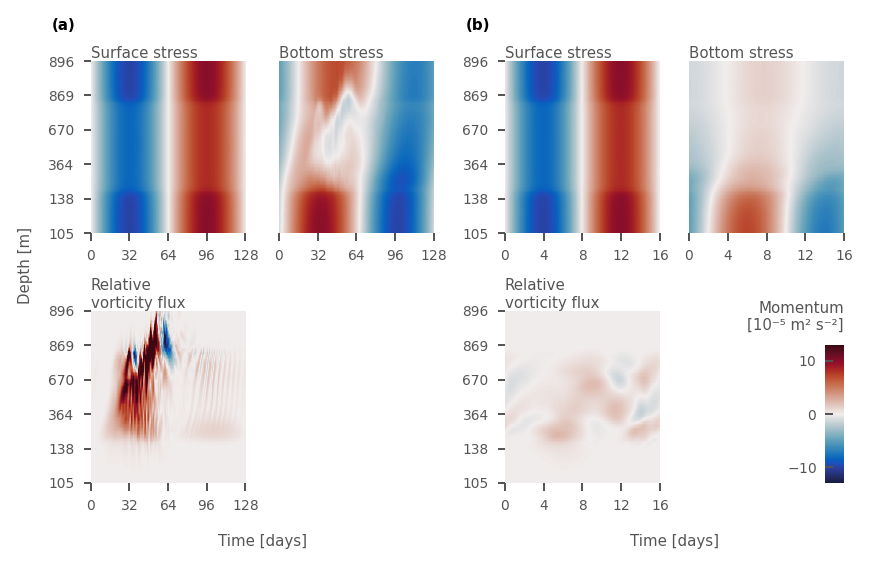

In [23]:
# --- Figure & layout ---------------------------------------------------------
(fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=0.6)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

# 2 subfigures (a,b) stacked; 3 panels each; one shared colorbar to the far right
axd = fig.subplot_mosaic(
    [
        ["a0", "a1", "b0", "b1"],
        ["a2", "aC", "b2", "cb"],  # aC is just an empty spacer
    ],
    gridspec_kw=dict(
        width_ratios=[1,1,1, 1],
        height_ratios=[1, 1],
    ),
)

for key, ax in axd.items():
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    
# --- Data prep ---------------------------------------------------------------
# Left / long (subfigure a)
terms = ["SS", "BS", "RVF"]
names = ["Surface stress", "Bottom stress", "Relative\nvorticity flux"]

tdays_L = dsH_L.time / np.timedelta64(1, "D")
Y_L     = ds_L.isel(yC=slice(ystart, ystop)).yC / 1e3

# Right / short (subfigure b)
dsH_Sp = dsH_S.isel(time=slice(-16*8-1, None), j=slice(ystart, ystop)).copy()
dsH_Sp["time"] = dsH_Sp["time"] - dsH_Sp["time"].isel(time=0)
tdays_S = dsH_Sp.time / np.timedelta64(1, "D")
Y_S     = ds_S.isel(yC=slice(ystart, ystop)).yC / 1e3

# One shared color scale across ALL panels (98th pct of abs across both subfigures)
vmax = np.nanmax([
    *[np.abs(dsH_L[term].isel(j=slice(ystart, ystop))).quantile(0.98) for term in terms],
    *[np.abs(dsH_Sp[term]).quantile(0.98) for term in terms],
]) * 1e5
vmin = -vmax

# --- Helpers: imshow with half-cell padding ---------------------------------
def _imshow(ax, Z, x, y, vmin, vmax, cmap):
    import numpy as np
    x = np.asarray(x); y = np.asarray(y)
    dx = np.diff(x).mean() if x.size > 1 else 1.0
    dy = np.diff(y).mean() if y.size > 1 else 1.0
    return ax.imshow(
        Z, origin="lower", aspect="auto",
        extent=[x[0]-dx/2, x[-1]+dx/2, y[0]-dy/2, y[-1]+dy/2],
        vmin=vmin, vmax=vmax, cmap=cmap
    )

# --- Subfigure (a): long -----------------------------------------------------
axes_a = [axd["a0"], axd["a1"], axd["a2"]]
for term, ax, name in zip(terms, axes_a, names):
    cm_a = _imshow(
        ax,
        dsH_L[term].isel(j=slice(ystart, ystop)).T * 1e5,
        tdays_L, Y_L,
        vmin, vmax, palette["cmdiv"]
    )
    ax.text(0.0, 1.0, name, ha="left", va="bottom", transform=ax.transAxes)
    ax.set_xticks(np.arange(0, 129, 32))

# y-ticks & dual labels on first and third panels
for key in ("a0", "a2"):
    axd[key].set_yticks(np.arange(20, 71, 10))
    axd[key].set_yticklabels([f"{h:.0f}" for h in H_targets[ystart:ystop+1:10]])

# hide redundant y-ticks on middle panel; turn spacer off
axd["a1"].set_yticks([])
axd["aC"].axis("off")

# --- Subfigure (b): short ----------------------------------------------------
axes_b = [axd["b0"], axd["b1"], axd["b2"]]
for term, ax, name in zip(terms, axes_b, names):
    cm_b = _imshow(
        ax,
        dsH_Sp[term].T * 1e5,
        tdays_S, Y_S,
        vmin, vmax, palette["cmdiv"]
    )
    ax.text(0.0, 1.0, name, ha="left", va="bottom", transform=ax.transAxes)
    ax.set_xlim(0, 16)
    ax.set_xticks(np.arange(0, 17, 4))

for key in ("b0", "b2"):
    axd[key].set_yticks(np.arange(20, 71, 10))
    axd[key].set_yticklabels([f"{h:.0f}" for h in H_targets[ystart:ystop+1:10]])

axd["b1"].set_yticks([])
#axd["bC"].axis("off")

# --- Labels & titles ---------------------------------------------------------
#fig.supxlabel("Time [days]")
fig.supylabel("Depth [m]", fontsize=6)

axd["a0"].text(-0.25, 1.25, "(a)", color="black",
               transform=axd["a0"].transAxes,
               va="top", fontweight="bold")
axd["b0"].text(-0.25, 1.25, "(b)", color="black",
               transform=axd["b0"].transAxes,
               va="top", fontweight="bold")

# --- Shared colorbar (far right, bottom) -----------------------
axd["cb"].axis("off")

cax = inset_axes(
    axd["cb"],
    width="12%",    # bar thickness (fraction of legend_b width)
    height="80%",  # bar length (fraction of legend_b height)
    loc="lower right",
    borderpad=0.0
)
cbar = plt.colorbar(cm_a, cax=cax, orientation="vertical")#, label="Momentum [10⁻⁵ m² s⁻²]")
cbar.ax.tick_params(direction="in")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_ticks_position("left")  # ticks on the left (adjacent to panels)
#cbar.ax.yaxis.set_label_position("left")
cbar.ax.set_title("Momentum\n[10⁻⁵ m² s⁻²]", loc="right", fontsize=6)  # label above bar

# --- Final touches & save ----------------------------------------------------
# ensure imshows don't get squashed in PDF
for key in ("a0","a1","a2","b0","b1","b2"):
    axd[key].set_aspect("auto", adjustable="box")

fig.canvas.draw()

def add_group_xlabel(keys, text, dy=0.1):
    # compute group bounds in figure fraction coords
    x0s, x1s, y0s = [], [], []
    for k in keys:
        pos = axd[k].get_position()
        x0s.append(pos.x0); x1s.append(pos.x1); y0s.append(pos.y0)
    xc = (min(x0s) + max(x1s)) / 2.0      # center of group
    y  = min(y0s) - dy                     # a bit below the lowest panel
    fig.text(xc, y, text, ha="center", va="top")

# one label under subfigure (a), and one under subfigure (b)
add_group_xlabel(["a0","a1","a2"], "Time [days]")
add_group_xlabel(["b0","b1","b2"], "Time [days]")

fig.savefig(figpath + "Hmomentum_terms.pdf")  # no bbox_inches with constrained layout


## Analysis on cartesian contours

In [24]:
# interpolate relevant variables to center position
dsY_L = interp_ds(ds_L, params_L, ["u", "v", "forcing_x", "detadx", "duvhdy"])
dsY_S = interp_ds(ds_S, params_S, ["u", "v", "forcing_x", "detadx", "duvhdy"])

dsY_L= dsY_L.isel(time=slice(focus_time_start_L,focus_time_stop_L))
dsY_S = dsY_S.isel(time=slice(focus_time_start_S,focus_time_stop_S))

#adjust time index so that t=0 is the beginning of the focus period
dsY_L["time"] = dsY_L.time - dsY_L.time.isel(time=0)
dsY_S["time"] = dsY_S.time - dsY_S.time.isel(time=0)

In [25]:
for dsY, params in zip([dsY_L, dsY_S], [params_L, params_S]):
    dsY["circulation"] = dsY.u.mean("xC")
    dsY["uH"] = (dsY.u*dsY.bath).mean("xC")
    dsY["BS"] = -(dsY.u).mean("xC")*params["R"]
    dsY["TFS"] = (-params["gravitational_acceleration"]*dsY.detadx*dsY.bath).mean("xC")
    dsY["MFC"] = (-dsY.duvhdy).mean("xC")
    dsY["SS"] = (dsY.forcing_x).mean("xC")

### Momentum diagrams

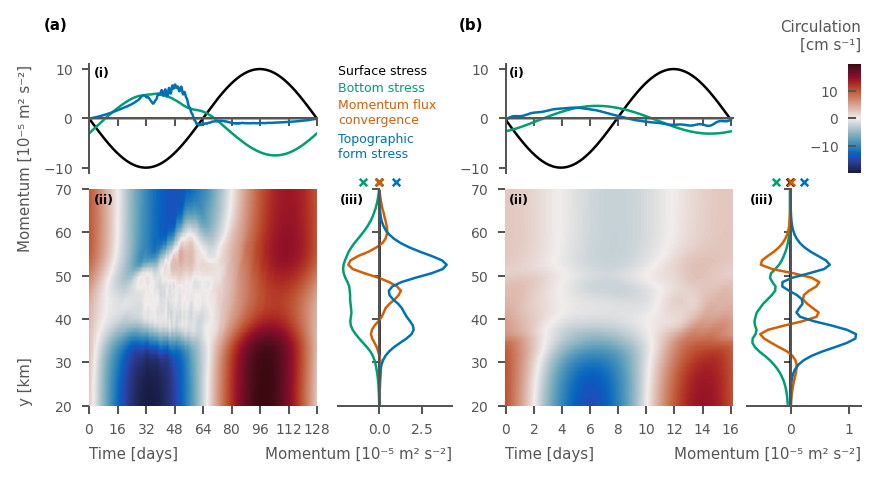

In [26]:
# --- Figure & layout ---------------------------------------------------------
(fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=0.53)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

axd = fig.subplot_mosaic(
    [
        ["ymean_a", "legend_a", "ymean_b", "legend_b"],
        ["circ_a",  "tmean_a",  "circ_b",  "tmean_b"],
    ],
    gridspec_kw=dict(
        height_ratios=[2, 4],
        width_ratios=[4, 2, 4, 2],
    ),
)

# Share axes (avoid redundant ticks/labels)
axd["ymean_a"].sharey(axd["ymean_b"])
for sub in ("a", "b"):
    axd[f"tmean_{sub}"].sharey(axd[f"circ_{sub}"])
    axd[f"ymean_{sub}"].sharex(axd[f"circ_{sub}"])

# Cosmetics & shared tick label suppression
for sub in ("a", "b"):
    customize_axis(axd[f"tmean_{sub}"], yzero=False)
    customize_axis(axd[f"ymean_{sub}"])
    customize_axis(axd[f"legend_{sub}"], yzero=False)
    axd[f"tmean_{sub}"].tick_params(labelleft=False)   # shared y with circ_*
    axd[f"ymean_{sub}"].tick_params(labelbottom=False) # shared x with circ_*
    
    # remove spines, keeping ticks
    axd[f"circ_{sub}"].spines['bottom'].set_visible(False)
    axd[f"circ_{sub}"].spines['left'].set_visible(False)

# Constrained layout padding
fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, wspace=0.02, hspace=0.02)


# --- Data prep & common color scale -----------------------------------------
# Left (long)
tdays_L  = dsY_L.time / np.timedelta64(1, "D")
Y_L      = ds_L.isel(yC=slice(ystart, ystop)).yC / 1e3

# Right (short) slice & re-zero its own time
dsY_Sp = dsY_S.isel(time=slice(-16*8-1, None), yC=slice(ystart, ystop)).copy()
dsY_Sp["time"] = dsY_Sp["time"] - dsY_Sp["time"].isel(time=0)
tdays_S  = dsY_Sp.time / np.timedelta64(1, "D")
Y_S      = ds_S.isel(yC=slice(ystart, ystop)).yC / 1e3

# Unified vlim across panels (so colors are comparable)
vlim = np.nanmax([
    np.abs(dsY_L.isel(yC=slice(ystart, ystop)).circulation).max(),
    np.abs(dsY_Sp.circulation).max(),
])*1e2


# --- LEFT PANEL (LONG) -------------------------------------------------------
# Half-cell padding so ticks at the ends show up with imshow
dt_L = np.diff(tdays_L).mean()
dy_L = np.diff(Y_L).mean()

cm_a = axd["circ_a"].imshow(
    dsY_L.isel(yC=slice(ystart, ystop)).circulation.T*1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_L[0] - dt_L/2, tdays_L[-1] + dt_L, Y_L[0] - dy_L/2, Y_L[-1] + dy_L/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# Optional for lightweight PDFs
# cm_a.set_rasterized(True)

# Ticks & labels
axd["circ_a"].set_xticks(np.arange(0, 129, 16))
axd["circ_a"].set_yticks(np.arange(20, 71, 10))
axd["circ_a"].set_xlabel("Time [days]", loc="left")
axd["circ_a"].set_ylabel("y [km]", loc="bottom")

# Lines: time-mean (over time) vs Y, and y-mean (over Y) vs time
for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean_L = dsY_L[term].isel(yC=slice(ystart, ystop)).mean("time") * 1e5
    axd["tmean_a"].plot(tmean_L, Y_L, color=colorwheel[i])

    ymean_L = dsY_L[term].isel(yC=slice(ystart, ystop)).mean("yC") * 1e5
    axd["ymean_a"].plot(tdays_L, ymean_L, color=colorwheel[i])

    # Marker at y-mean of the time series (placed slightly above the top)
    ytmean_L = ymean_L.mean("time")
    axd["tmean_a"].scatter(ytmean_L, Y_L[-1] + 2, marker="x", color=colorwheel[i], clip_on=False)

    # Collect legend handles in its own axis
    axd["legend_a"].plot([None, None], [None, None], label=term, color=colorwheel[i])

# Legend (left legend axis)
axd["legend_a"].axis("off")
# axd["legend_a"].legend(
#     ["SS", "BS", "MFC", "TFS"],
#     loc="upper left", frameon=False, fontsize=5, bbox_to_anchor=(0, 1.15)
# )
labels = ["Surface stress", "Bottom stress", "Momentum flux\nconvergence", "Topographic\nform stress"]
y_start = 1
line_height = 0.15  # adjust this once
y = y_start
for label, color in zip(labels, colorwheel):
    axd["legend_a"].text(
        0.0, y,
        label,
        color=color,
        fontsize=5,
        transform=axd["legend_a"].transAxes,
        ha="left", va="top"
    )
    n_lines = label.count("\n") + 1
    y -= n_lines * line_height + 0.01  # small gap between entries

# Axes labels for side panels
axd["ymean_a"].set_ylabel("Momentum [10⁻⁵ m² s⁻²]", loc="top")
axd["tmean_a"].set_xlabel("Momentum [10⁻⁵ m² s⁻²]", loc="right")


# --- RIGHT PANEL (SHORT) -----------------------------------------------------
dt_S = np.diff(tdays_S).mean()
dy_S = np.diff(Y_S).mean()

cm_b = axd["circ_b"].imshow(
    dsY_Sp.circulation.T*1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_S[0] - dt_S/2, tdays_S[-1] + dt_S, Y_S[0] - dy_S/2, Y_S[-1] + dy_S/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# cm_b.set_rasterized(True)

axd["circ_b"].set_xticks(np.arange(0, 17, 2))
axd["circ_b"].set_yticks(np.arange(20, 71, 10))
axd["circ_b"].set_xlabel("Time [days]", loc="left")

for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean_S = dsY_Sp[term].mean("time") * 1e5
    axd["tmean_b"].plot(tmean_S, Y_S, color=colorwheel[i])

    ymean_S = dsY_Sp[term].mean("yC") * 1e5
    axd["ymean_b"].plot(tdays_S, ymean_S, color=colorwheel[i])

    ytmean_S = ymean_S.mean("time")
    axd["tmean_b"].scatter(ytmean_S, Y_S[-1] + 2, marker="x", color=colorwheel[i], clip_on=False)

    axd["legend_b"].plot([None, None], [None, None], label=term, color=colorwheel[i])

axd["legend_b"].axis("off")

# Colorbar in legend_b, sharing cm_a normalization
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cax = inset_axes(axd["legend_b"], width="12%", height="100%", loc="center right", borderpad=0.0)
cbar = plt.colorbar(cm_a, cax=cax, orientation="vertical")
cbar.ax.tick_params(direction="in")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_ticks_position("left")
cax.set_title("Circulation\n[cm s⁻¹]", fontsize=6, loc="right")

# Axes labels for side panels
axd["tmean_b"].set_xlabel("Momentum [10⁻⁵ m² s⁻²]", loc="right")
axd["tmean_a"].set_ylim(ystart, ystop)  # lock tmean ranges to panel height
axd["tmean_b"].set_ylim(ystart, ystop)

# --- Panel annotations --------------------------------------------------------
for sub in ("a", "b"):
    for panel, text in zip(("ymean_", "circ_", "tmean_"), ("(i)", "(ii)", "(iii)")):
        axd[panel + sub].text(
            0.02, 0.98, text, color="black",
            transform=axd[panel + sub].transAxes,
            va="top", fontweight="bold", fontsize=5
        )
    axd["ymean_" + sub].text(
        -0.2, 1.43, f"({sub})", color="black",
        transform=axd["ymean_" + sub].transAxes,
        va="top", fontweight="bold", fontsize=6
    )

# Align any remaining shared labels (once, near the end)
fig.align_labels()

# --- Save --------------------------------------------------------------------
fig.savefig(figpath + "Ymomentum.pdf")


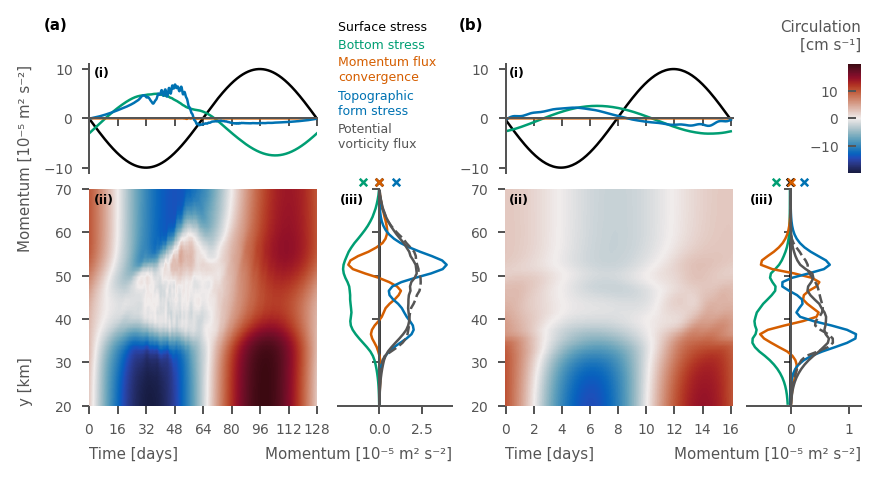

In [49]:
# --- Figure & layout ---------------------------------------------------------
(fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=0.53)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

axd = fig.subplot_mosaic(
    [
        ["ymean_a", "legend_a", "ymean_b", "legend_b"],
        ["circ_a",  "tmean_a",  "circ_b",  "tmean_b"],
    ],
    gridspec_kw=dict(
        height_ratios=[2, 4],
        width_ratios=[4, 2, 4, 2],
    ),
)

# Share axes (avoid redundant ticks/labels)
axd["ymean_a"].sharey(axd["ymean_b"])
for sub in ("a", "b"):
    axd[f"tmean_{sub}"].sharey(axd[f"circ_{sub}"])
    axd[f"ymean_{sub}"].sharex(axd[f"circ_{sub}"])

# Cosmetics & shared tick label suppression
for sub in ("a", "b"):
    customize_axis(axd[f"tmean_{sub}"], yzero=False)
    customize_axis(axd[f"ymean_{sub}"])
    customize_axis(axd[f"legend_{sub}"], yzero=False)
    axd[f"tmean_{sub}"].tick_params(labelleft=False)   # shared y with circ_*
    axd[f"ymean_{sub}"].tick_params(labelbottom=False) # shared x with circ_*
    
    # remove spines, keeping ticks
    axd[f"circ_{sub}"].spines['bottom'].set_visible(False)
    axd[f"circ_{sub}"].spines['left'].set_visible(False)

# Constrained layout padding
fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, wspace=0.02, hspace=0.02)


# --- Data prep & common color scale -----------------------------------------
# Left (long)
tdays_L  = dsY_L.time / np.timedelta64(1, "D")
Y_L      = ds_L.isel(yC=slice(ystart, ystop)).yC / 1e3

# Right (short) slice & re-zero its own time
dsY_Sp = dsY_S.isel(time=slice(-16*8-1, None), yC=slice(ystart, ystop)).copy()
dsY_Sp["time"] = dsY_Sp["time"] - dsY_Sp["time"].isel(time=0)
tdays_S  = dsY_Sp.time / np.timedelta64(1, "D")
Y_S      = ds_S.isel(yC=slice(ystart, ystop)).yC / 1e3

# Unified vlim across panels (so colors are comparable)
vlim = np.nanmax([
    np.abs(dsY_L.isel(yC=slice(ystart, ystop)).circulation).max(),
    np.abs(dsY_Sp.circulation).max(),
])*1e2


# --- LEFT PANEL (LONG) -------------------------------------------------------
# Half-cell padding so ticks at the ends show up with imshow
dt_L = np.diff(tdays_L).mean()
dy_L = np.diff(Y_L).mean()

cm_a = axd["circ_a"].imshow(
    dsY_L.isel(yC=slice(ystart, ystop)).circulation.T*1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_L[0] - dt_L/2, tdays_L[-1] + dt_L, Y_L[0] - dy_L/2, Y_L[-1] + dy_L/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)

# Ticks & labels
axd["circ_a"].set_xticks(np.arange(0, 129, 16))
axd["circ_a"].set_yticks(np.arange(20, 71, 10))
axd["circ_a"].set_xlabel("Time [days]", loc="left")
axd["circ_a"].set_ylabel("y [km]", loc="bottom")

# Lines: time-mean (over time) vs Y, and y-mean (over Y) vs time
for i, term in enumerate(["SS", "BS", "MFC", "TFS", "sum"]):
    if term == "sum":
        tmean_L = (dsY_L["MFC"]+dsY_L["TFS"]).isel(yC=slice(ystart, ystop)).mean("time") * 1e5
        axd["tmean_a"].plot(tmean_L, Y_L, colorwheel[i])

        tmean_L = dsH_L["RVF"].isel(j=slice(ystart, ystop)).mean("time") * 1e5
        axd["tmean_a"].plot(tmean_L, equivY_L, colorwheel[i], ls="--")
    else:
        tmean_L = dsY_L[term].isel(yC=slice(ystart, ystop)).mean("time") * 1e5
        axd["tmean_a"].plot(tmean_L, Y_L, color=colorwheel[i])

        ymean_L = dsY_L[term].isel(yC=slice(ystart, ystop)).mean("yC") * 1e5
        axd["ymean_a"].plot(tdays_L, ymean_L, color=colorwheel[i])

        # Marker at y-mean of the time series (placed slightly above the top)
        ytmean_L = ymean_L.mean("time")
        axd["tmean_a"].scatter(ytmean_L, Y_L[-1] + 2, marker="x", color=colorwheel[i], clip_on=False)

        # Collect legend handles in its own axis
        axd["legend_a"].plot([None, None], [None, None], label=term, color=colorwheel[i])

# Legend (left legend axis)
axd["legend_a"].axis("off")
# axd["legend_a"].legend(
#     ["SS", "BS", "MFC", "TFS"],
#     loc="upper left", frameon=False, fontsize=5, bbox_to_anchor=(0, 1.15)
# )
labels = ["Surface stress", "Bottom stress", "Momentum flux\nconvergence", "Topographic\nform stress", "Potential\nvorticity flux"]
y_start = 1.4
line_height = 0.15  # adjust this once
y = y_start
for label, color in zip(labels, colorwheel):
    axd["legend_a"].text(
        0.0, y,
        label,
        color=color,
        fontsize=5,
        transform=axd["legend_a"].transAxes,
        ha="left", va="top"
    )
    n_lines = label.count("\n") + 1
    y -= n_lines * line_height + 0.01  # small gap between entries

# Axes labels for side panels
axd["ymean_a"].set_ylabel("Momentum [10⁻⁵ m² s⁻²]", loc="top")
axd["tmean_a"].set_xlabel("Momentum [10⁻⁵ m² s⁻²]", loc="right")


# --- RIGHT PANEL (SHORT) -----------------------------------------------------
dt_S = np.diff(tdays_S).mean()
dy_S = np.diff(Y_S).mean()

cm_b = axd["circ_b"].imshow(
    dsY_Sp.circulation.T*1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_S[0] - dt_S/2, tdays_S[-1] + dt_S, Y_S[0] - dy_S/2, Y_S[-1] + dy_S/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# cm_b.set_rasterized(True)

axd["circ_b"].set_xticks(np.arange(0, 17, 2))
axd["circ_b"].set_yticks(np.arange(20, 71, 10))
axd["circ_b"].set_xlabel("Time [days]", loc="left")

for i, term in enumerate(["SS", "BS", "MFC", "TFS", "sum"]):
    if term == "sum":
        tmean_S = (dsY_Sp["MFC"]+dsY_Sp["TFS"]).mean("time") * 1e5
        axd["tmean_b"].plot(tmean_S, Y_S, color=colorwheel[i])

        tmean_S = dsH_Sp["RVF"].mean("time") * 1e5
        axd["tmean_b"].plot(tmean_S, equivY_S, color=colorwheel[i], ls="--")
    else:
        tmean_S = dsY_Sp[term].mean("time") * 1e5
        axd["tmean_b"].plot(tmean_S, Y_S, color=colorwheel[i])

        ymean_S = dsY_Sp[term].mean("yC") * 1e5
        axd["ymean_b"].plot(tdays_S, ymean_S, color=colorwheel[i])

        ytmean_S = ymean_S.mean("time")
        axd["tmean_b"].scatter(ytmean_S, Y_S[-1] + 2, marker="x", color=colorwheel[i], clip_on=False)

        axd["legend_b"].plot([None, None], [None, None], label=term, color=colorwheel[i])

axd["legend_b"].axis("off")

# Colorbar in legend_b, sharing cm_a normalization
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cax = inset_axes(axd["legend_b"], width="12%", height="100%", loc="center right", borderpad=0.0)
cbar = plt.colorbar(cm_a, cax=cax, orientation="vertical")
cbar.ax.tick_params(direction="in")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_ticks_position("left")
cax.set_title("Circulation\n[cm s⁻¹]", fontsize=6, loc="right")

# Axes labels for side panels
axd["tmean_b"].set_xlabel("Momentum [10⁻⁵ m² s⁻²]", loc="right")
axd["tmean_a"].set_ylim(ystart, ystop)  # lock tmean ranges to panel height
axd["tmean_b"].set_ylim(ystart, ystop)

# --- Panel annotations --------------------------------------------------------
for sub in ("a", "b"):
    for panel, text in zip(("ymean_", "circ_", "tmean_"), ("(i)", "(ii)", "(iii)")):
        axd[panel + sub].text(
            0.02, 0.98, text, color="black",
            transform=axd[panel + sub].transAxes,
            va="top", fontweight="bold", fontsize=5
        )
    axd["ymean_" + sub].text(
        -0.2, 1.43, f"({sub})", color="black",
        transform=axd["ymean_" + sub].transAxes,
        va="top", fontweight="bold", fontsize=6
    )

# Align any remaining shared labels (once, near the end)
fig.align_labels()

# --- Save --------------------------------------------------------------------
fig.savefig(figpath + "Ymomentum_alt.pdf")


In [28]:
# # --- Figure & layout: only panel (a) -----------------------------------------
# (fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=1)
# fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

# axd = fig.subplot_mosaic(
#     [
#         ["ymean_a", "legend_a"],
#         ["circ_a",  "tmean_a"],
#     ],
#     gridspec_kw=dict(
#         height_ratios=[2.5, 4],
#         width_ratios=[4, 2],
#     ),
# )

# # Share axes (avoid redundant ticks/labels)
# axd["tmean_a"].sharey(axd["circ_a"])
# axd["ymean_a"].sharex(axd["circ_a"])

# # Cosmetics & shared tick label suppression
# customize_axis(axd["tmean_a"], yzero=False)
# customize_axis(axd["ymean_a"])
# customize_axis(axd["legend_a"], yzero=False)

# axd["tmean_a"].tick_params(labelleft=False)    # shared y with circ_a
# axd["ymean_a"].tick_params(labelbottom=False)  # shared x with circ_a

# # remove spines, keeping ticks
# axd["circ_a"].spines['bottom'].set_visible(False)
# axd["circ_a"].spines['left'].set_visible(False)

# # # Constrained layout padding
# # fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, wspace=0.02, hspace=0.02)


# # --- Data prep & color scale (LONG only) ------------------------------------
# tdays_L  = dsY_L.time / np.timedelta64(1, "D")
# Y_L      = ds_L.isel(yC=slice(ystart, ystop)).yC / 1e3

# # vlim from long run only (as in Hmomentum_panel_a)
# vlim = np.max(np.abs(dsY_L.isel(yC=slice(ystart, ystop)).circulation * 1e2))

# # Half-cell padding so ticks at the ends show up with imshow
# dt_L = np.diff(tdays_L).mean()
# dy_L = np.diff(Y_L).mean()

# cm_a = axd["circ_a"].imshow(
#     dsY_L.isel(yC=slice(ystart, ystop)).circulation.T * 1e2,
#     origin="lower",
#     aspect="auto",
#     extent=[tdays_L[0] - dt_L/2, tdays_L[-1] + dt_L/2,
#             Y_L[0] - dy_L/2,     Y_L[-1] + dy_L/2],
#     vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
# )

# # Ticks & labels (with fontsize)
# axd["circ_a"].set_xticks(np.arange(0, 129, 16))
# axd["circ_a"].set_yticks(np.arange(20, 71, 10))
# axd["circ_a"].set_xlabel("Time [days]", fontsize=9)
# axd["circ_a"].set_ylabel("y [km]", fontsize=9)
# axd["circ_a"].tick_params(axis='both', which='major', labelsize=9)


# # --- Lines: time-mean vs y, and y-mean vs time ------------------------------
# for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
#     # time-mean over time vs Y
#     tmean_L = dsY_L[term].isel(yC=slice(ystart, ystop)).mean("time") * 1e5
#     axd["tmean_a"].plot(tmean_L, Y_L, color=colorwheel[i], lw=2)

#     # mean over yC vs time
#     ymean_L = dsY_L[term].isel(yC=slice(ystart, ystop)).mean("yC") * 1e5
#     axd["ymean_a"].plot(tdays_L, ymean_L, color=colorwheel[i], lw=2)

#     # Marker at time-mean of y-mean series (above top)
#     ytmean_L = ymean_L.mean("time")
#     axd["tmean_a"].scatter(ytmean_L, Y_L[-1] -1 , marker="x", s=36,
#                            color=colorwheel[i], clip_on=False,zorder=30)

#     # Collect legend handles in its own axis
#     axd["legend_a"].plot([None, None], [None, None], label=term, color=colorwheel[i])

# # Legend (left legend axis)
# axd["legend_a"].axis("off")
# labels = [
#     "Surface stress",
#     "Bottom stress",
#     "Momentum flux\nconvergence",
#     "Topographic\nform stress",
# ]
# y_start = 1
# line_height = 0.15
# y = y_start
# for label, color in zip(labels, colorwheel):
#     axd["legend_a"].text(
#         0.0, y,
#         label,
#         color=color,
#         fontsize=9,
#         transform=axd["legend_a"].transAxes,
#         ha="left", va="top",
#     )
#     n_lines = label.count("\n") + 1
#     y -= n_lines * line_height + 0.01  # small gap between entries

# # Axes labels for side panels
# axd["ymean_a"].set_ylabel("Momentum [10⁻⁵ m² s⁻²]", loc="top", fontsize=9)
# axd["tmean_a"].set_xlabel("Momentum [10⁻⁵ m² s⁻²]", loc="right", fontsize=9)
# axd["ymean_a"].tick_params(axis='both', which='major', labelsize=9)
# axd["tmean_a"].tick_params(axis='both', which='major', labelsize=9)

# axd["ymean_a"].set_ylim(-11,17)
# fig.align_labels()


# # --- Make background transparent ---------------------------------------------
# for ax in axd.values():
#     ax.set_facecolor('none')   # transparent axes

# fig.patch.set_alpha(0)         # transparent figure background


# # --- Save as SVG with transparent background --------------------------------
# fig.savefig(
#     figpath + "Ymomentum_panel_a.svg",
#     format="svg",
#     transparent=True,
#     bbox_inches="tight",
# )



### Individual momentum terms

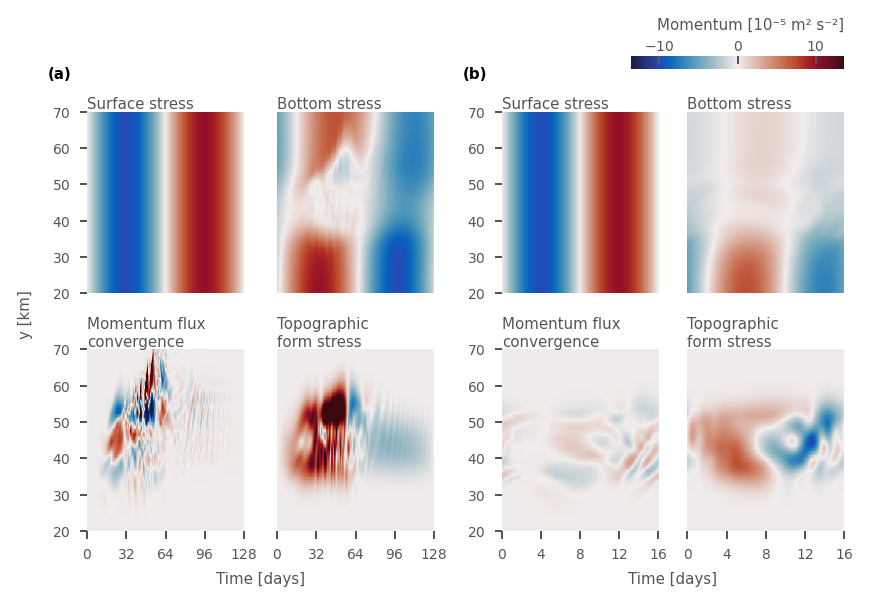

In [29]:
# --- Figure & layout ---------------------------------------------------------
(fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=0.6)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

# 2 subfigures (a,b) side-by-side groups, each with 2x2 panels; no colorbar
axd = fig.subplot_mosaic(
    [
        ["a0", "a1", "b0", "b1"],
        ["a2", "a3", "b2", "b3"],
    ],
    gridspec_kw=dict(width_ratios=[1, 1, 1, 1], height_ratios=[1, 1]),
)

# Clean spines (match your style)
for ax in axd.values():
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)

# --- Data prep ---------------------------------------------------------------
terms = ["SS", "BS", "MFC", "TFS"]
names = ["Surface stress", "Bottom stress", "Momentum flux\nconvergence", "Topographic\nform stress"]

# (a) long
tdays_L = dsY_L.time / np.timedelta64(1, "D")
Y_L     = ds_L.isel(yC=slice(ystart, ystop)).yC / 1e3

# (b) short (time re-zeroed)
dsY_Sp = dsY_S.isel(time=slice(-16*8-1, None), yC=slice(ystart, ystop)).copy()
dsY_Sp["time"] = dsY_Sp["time"] - dsY_Sp["time"].isel(time=0)
tdays_S = dsY_Sp.time / np.timedelta64(1, "D")
Y_S     = ds_S.isel(yC=slice(ystart, ystop)).yC / 1e3

# Shared symmetric color scale via 98th percentile across BOTH subfigures
vmax = np.nanmax([
    *[np.abs(dsY_L[term].isel(yC=slice(ystart, ystop))).quantile(0.98) for term in terms],
    *[np.abs(dsY_Sp[term]).quantile(0.98) for term in terms],
]) * 1e5
vmin = -vmax

# --- Helper: imshow with half-cell padding ----------------------------------
def _imshow(ax, Z, x, y, vmin, vmax, cmap):
    x = np.asarray(x); y = np.asarray(y)
    dx = np.diff(x).mean() if x.size > 1 else 1.0
    dy = np.diff(y).mean() if y.size > 1 else 1.0
    return ax.imshow(
        Z, origin="lower", aspect="auto",
        extent=[x[0]-dx/2, x[-1]+dx/2, y[0]-dy/2, y[-1]+dy/2],
        vmin=vmin, vmax=vmax, cmap=cmap
    )

# --- Subfigure (a): four panels ----------------------------------------------
axes_a = [axd["a0"], axd["a1"], axd["a2"], axd["a3"]]
for term, ax, name in zip(terms, axes_a, names):
    cm_a = _imshow(
        ax,
        dsY_L[term].isel(yC=slice(ystart, ystop)).T * 1e5,
        tdays_L, Y_L, vmin, vmax, palette["cmdiv"]
    )
    ax.text(0.0, 1.0, name, ha="left", va="bottom", transform=ax.transAxes)
# ticks: hide x on top row, hide y on right col
for key in ("a0", "a1"): axd[key].set_xticks([])
for key in ("a1", "a3"): axd[key].set_yticks([])
# bottom row x ticks/limits
for key in ("a2", "a3"):
    axd[key].set_xticks(np.arange(0, 129, 32))
# y ticks on left column
for key in ("a0", "a2"):
    axd[key].set_yticks(np.arange(20, 71, 10))

# --- Subfigure (b): four panels ----------------------------------------------
axes_b = [axd["b0"], axd["b1"], axd["b2"], axd["b3"]]
for term, ax, name in zip(terms, axes_b, names):
    cm_b = _imshow(
        ax,
        dsY_Sp[term].T * 1e5,
        tdays_S, Y_S, vmin, vmax, palette["cmdiv"]
    )
    ax.text(0.0, 1.0, name, ha="left", va="bottom", transform=ax.transAxes)
# ticks: hide x on top row, hide y on right col
for key in ("b0", "b1"): axd[key].set_xticks([])
for key in ("b1", "b3"): axd[key].set_yticks([])
# bottom row x ticks/limits (0–16 days)
for key in ("b2", "b3"):
    axd[key].set_xlim(0, 16)
    axd[key].set_xticks(np.arange(0, 17, 4))
# y ticks on left column
for key in ("b0", "b2"):
    axd[key].set_yticks(np.arange(20, 71, 10))

# --- Subfigure labels & group x-labels ---------------------------------------
axd["a0"].text(-0.25, 1.25, "(a)", color="black",
               transform=axd["a0"].transAxes, va="top", fontweight="bold")
axd["b0"].text(-0.25, 1.25, "(b)", color="black",
               transform=axd["b0"].transAxes, va="top", fontweight="bold")

fig.supylabel("y [km]", fontsize=6)

# finalize layout so positions are accurate for group xlabels
fig.canvas.draw()

def add_group_xlabel(keys, text, dy=0.08):
    x0s, x1s, y0s = [], [], []
    for k in keys:
        pos = axd[k].get_position()
        x0s.append(pos.x0); x1s.append(pos.x1); y0s.append(pos.y0)
    xc = (min(x0s) + max(x1s)) / 2.0
    y  = min(y0s) - dy
    fig.text(xc, y, text, ha="center", va="top")

# one label under subfigure (a), and one under subfigure (b)
add_group_xlabel(["a0", "a1", "a2", "a3"], "Time [days]")
add_group_xlabel(["b0", "b1", "b2", "b3"], "Time [days]")

# --- Final touches & save ----------------------------------------------------
for key in ("a0","a1","a2","a3","b0","b1","b2","b3"):
    axd[key].set_aspect("auto", adjustable="box")

fig.canvas.draw()


# --- Add horizontal colorbar in the top-right corner -------------------------
# Define position in figure coordinates (fractions)
cbar_width  = 0.25   # fraction of figure width
cbar_height = 0.025  # fraction of figure height
cbar_x0     = 0.73   # move right to align above subfigure (b)
cbar_y0     = 0.98   # just above top panels

# Create new axis for colorbar
cax = fig.add_axes([cbar_x0, cbar_y0, cbar_width, cbar_height])

# Create the colorbar from cm_a (shared normalization)
cbar = fig.colorbar(cm_a, cax=cax, orientation="horizontal")

# --- Style tweaks ---
cbar.ax.tick_params(direction="in", top=True, bottom=False, pad=1)
cbar.outline.set_visible(False)
cbar.ax.xaxis.set_ticks_position("top")   # ticks on top
cbar.ax.xaxis.set_label_position("top")   # label above bar
cbar.set_label("Momentum [10⁻⁵ m² s⁻²]", loc="right")

fig.savefig(figpath + "Ymomentum_terms.pdf", bbox_inches="tight", pad_inches=0.02)


## PV flux 

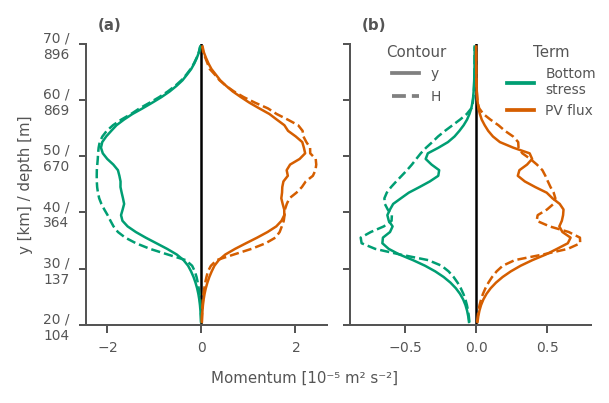

In [111]:
(fig_width_in, fig_height_in), _ = get_figure_dimensions("single", aspect_ratio=0.65)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

axd = fig.subplot_mosaic([["long", "short"]], sharey=True)

for ax in axd.values():
    ax.axvline(0, color="black")
    #customize_axis(ax, yzero=False)

yticks = np.arange(20, 71, 10)
ax = axd["long"]
ax.set_yticks(yticks)
ax.set_ylim(ystart, ystop)

# corresponding depth values
depths = H_targets[ystart:ystop+1:10]

# safety check: lengths must match
assert len(yticks) == len(depths)

# build labels
yticklabels = [f"{y:.0f} /\n{int(H)}" for y, H in zip(yticks, depths)]
ax.set_yticklabels(yticklabels)

# ylabel
ax.set_ylabel("y [km] / depth [m]")

fig.supxlabel("Momentum [10⁻⁵ m² s⁻²]", fontsize=6)

SCALE = 1e5
slY = dict(yC=slice(ystart, ystop))
slH = dict(j=slice(ystart, ystop))

cases = {
    "long": dict(ax=axd["long"], dsY=dsY_L, dsH=dsH_L, Y=Y_L, YH=equivY_L, slY=slY, slH=slH),
    "short": dict(ax=axd["short"], dsY=dsY_Sp, dsH=dsH_Sp, Y=Y_S, YH=equivY_S, slY={},  slH={}),
}

def _plot_case(case, term, color):
    ax, dsY, dsH = case["ax"], case["dsY"], case["dsH"]
    Y, YH, slY, slH = case["Y"], case["YH"], case["slY"], case["slH"]

    if term == "sum":
        yterm = (dsY["MFC"] + dsY["TFS"])
        hterm = dsH["RVF"]
    else:
        yterm = dsY[term]
        hterm = dsH[term]

    ax.plot(yterm.isel(**slY).mean("time") * SCALE, Y,  color=color)
    ax.plot(hterm.isel(**slH).mean("time") * SCALE, YH, color=color, ls="--")

for i, term in enumerate(("BS", "sum")):
    col = colorwheel[i+1]
    for case in cases.values():
        _plot_case(case, term, col)
        
# add labels (a) and (b)
axd["long"].text(0.05, 1.05, "(a)", transform=axd["long"].transAxes,fontweight='bold')
axd["short"].text(0.05, 1.05,"(b)", transform=axd["short"].transAxes, fontweight='bold')


# --- Legends ---
# Color legend (terms)
term_handles = [
    Line2D([0], [0], color=colorwheel[1], lw=1.5, label="Bottom\nstress"),
    Line2D([0], [0], color=colorwheel[2], lw=1.5, label="PV flux"),
]

# Line-style legend (diagnostic framework; grey only)
framework_handles = [
    Line2D([0], [0], color="grey", lw=1.5, ls="-",  label=r"$y$"),
    Line2D([0], [0], color="grey", lw=1.5, ls="--", label=r"$H$"),
]

ax0 = axd["short"]  # anchor both legends to left panel

leg_terms = ax0.legend(
    handles=term_handles, title="Term", 
    frameon=False, loc="upper left", bbox_to_anchor=(0.6, 1.04)
)
leg_framework = ax0.legend(
    handles=framework_handles, title="Contour",
    frameon=False, loc="upper left", bbox_to_anchor=(0.1, 1.04)
)
ax0.add_artist(leg_terms)
fig.savefig(figpath + "PVflux.pdf")

## No bumps

In [30]:
# # read simulation output
paramsnb_L = load_config("../configs/baseline_forcing/long_nobumps.json")
dsnb_L = read_raw_output(paramsnb_L)
paramsnb_S = load_config("../configs/baseline_forcing/short_nobumps.json")
dsnb_S = read_raw_output(paramsnb_S)

# # interpolate relevant variables to center position
dsYnb_L = interp_ds(dsnb_L, paramsnb_L, ["u", "v", "forcing_x", "detadx", "duvhdy"])
dsYnb_S = interp_ds(dsnb_S, paramsnb_S, ["u", "v", "forcing_x", "detadx", "duvhdy"])

dsYnb_L= dsYnb_L.isel(time=slice(focus_time_start_L,focus_time_stop_L))
dsYnb_S = dsYnb_S.isel(time=slice(-(16+8)*8,-8*8))

# #adjust time index so that t=0 is the beginning of the focus period
dsYnb_L["time"] = dsYnb_L.time - dsYnb_L.time.isel(time=0)
dsYnb_S["time"] = dsYnb_S.time - dsYnb_S.time.isel(time=0)

Loading configuration from ../configs/baseline_forcing/long_nobumps.json
Loading configuration from ../configs/baseline_forcing/short_nobumps.json


In [31]:
for dsY, params in zip([dsYnb_L, dsYnb_S], [paramsnb_L, paramsnb_S]):
    dsY["circulation"] = dsY.u.mean("xC")
    dsY["uH"] = (dsY.u*dsY.bath).mean("xC")
    dsY["BS"] = -(dsY.u).mean("xC")*params["R"]
    dsY["TFS"] = (-params["gravitational_acceleration"]*dsY.detadx*dsY.bath).mean("xC")
    dsY["MFC"] = (-dsY.duvhdy).mean("xC")
    dsY["SS"] = (dsY.forcing_x).mean("xC")

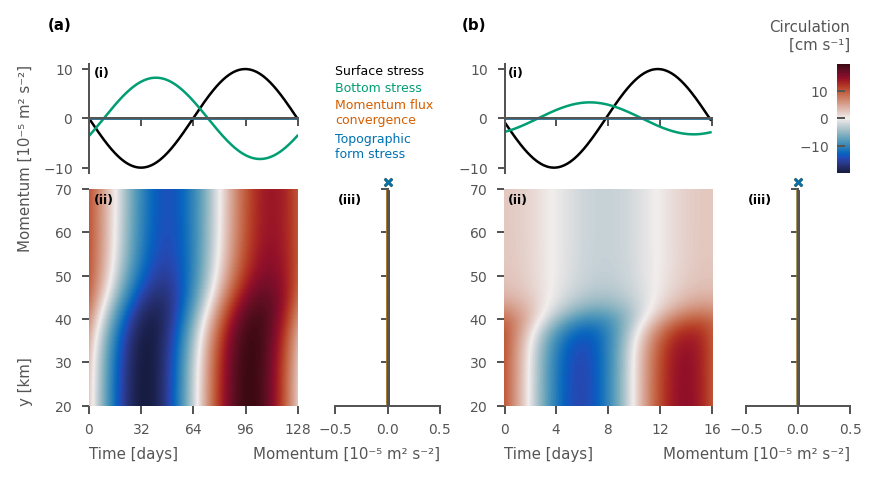

In [32]:
# --- Figure & layout ---------------------------------------------------------
(fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=0.53)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

axd = fig.subplot_mosaic(
    [
        ["ymean_a", "legend_a", "ymean_b", "legend_b"],
        ["circ_a",  "tmean_a",  "circ_b",  "tmean_b"],
    ],
    gridspec_kw=dict(
        height_ratios=[2, 4],
        width_ratios=[4, 2, 4, 2],
    ),
)

# Share axes (avoid redundant ticks/labels)
axd["ymean_a"].sharey(axd["ymean_b"])
for sub in ("a", "b"):
    axd[f"tmean_{sub}"].sharey(axd[f"circ_{sub}"])
    axd[f"ymean_{sub}"].sharex(axd[f"circ_{sub}"])

# Cosmetics & shared tick label suppression
for sub in ("a", "b"):
    customize_axis(axd[f"tmean_{sub}"], yzero=False)
    customize_axis(axd[f"ymean_{sub}"])
    customize_axis(axd[f"legend_{sub}"], yzero=False)
    axd[f"tmean_{sub}"].tick_params(labelleft=False)   # shared y with circ_*
    axd[f"ymean_{sub}"].tick_params(labelbottom=False) # shared x with circ_*
    
    # remove spines, keeping ticks
    axd[f"circ_{sub}"].spines['bottom'].set_visible(False)
    axd[f"circ_{sub}"].spines['left'].set_visible(False)

# Constrained layout padding
fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, wspace=0.02, hspace=0.02)


# --- Data prep & common color scale -----------------------------------------
# Left (long)
tdays_L  = dsYnb_L.time / np.timedelta64(1, "D")
Y_L      = ds_L.isel(yC=slice(ystart, ystop)).yC / 1e3

# Right (short) slice & re-zero its own time
tdays_S  = dsYnb_S.time / np.timedelta64(1, "D")
Y_S      = ds_S.isel(yC=slice(ystart, ystop)).yC / 1e3

# Unified vlim across panels (so colors are comparable)
vlim = np.nanmax([
    np.abs(dsYnb_L.isel(yC=slice(ystart, ystop)).circulation).max(),
    np.abs(dsYnb_S.circulation).max(),
])*1e2


# --- LEFT PANEL (LONG) -------------------------------------------------------
# Half-cell padding so ticks at the ends show up with imshow
dt_L = np.diff(tdays_L).mean()
dy_L = np.diff(Y_L).mean()

cm_a = axd["circ_a"].imshow(
    dsYnb_L.isel(yC=slice(ystart, ystop)).circulation.T*1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_L[0] - dt_L/2, tdays_L[-1] + dt_L, Y_L[0] - dy_L/2, Y_L[-1] + dy_L/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# Optional for lightweight PDFs
# cm_a.set_rasterized(True)

# Ticks & labels
axd["circ_a"].set_xticks(np.arange(0, 129, 32))
axd["circ_a"].set_yticks(np.arange(20, 71, 10))
axd["circ_a"].set_xlabel("Time [days]", loc="left")
axd["circ_a"].set_ylabel("y [km]", loc="bottom")

# Lines: time-mean (over time) vs Y, and y-mean (over Y) vs time
for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean_L = dsYnb_L[term].isel(yC=slice(ystart, ystop)).mean("time") * 1e5
    axd["tmean_a"].plot(tmean_L, Y_L, color=colorwheel[i])

    ymean_L = dsYnb_L[term].isel(yC=slice(ystart, ystop)).mean("yC") * 1e5
    axd["ymean_a"].plot(tdays_L, ymean_L, color=colorwheel[i])

    # Marker at y-mean of the time series (placed slightly above the top)
    ytmean_L = ymean_L.mean("time")
    axd["tmean_a"].scatter(ytmean_L, Y_L[-1] + 2, marker="x", color=colorwheel[i], clip_on=False)

    # Collect legend handles in its own axis
    axd["legend_a"].plot([None, None], [None, None], label=term, color=colorwheel[i])

# Legend (left legend axis)
axd["legend_a"].axis("off")
# axd["legend_a"].legend(
#     ["SS", "BS", "MFC", "TFS"],
#     loc="upper left", frameon=False, fontsize=5, bbox_to_anchor=(0, 1.15)
# )
labels = ["Surface stress", "Bottom stress", "Momentum flux\nconvergence", "Topographic\nform stress"]
y_start = 1
line_height = 0.15  # adjust this once
y = y_start
for label, color in zip(labels, colorwheel):
    axd["legend_a"].text(
        0.0, y,
        label,
        color=color,
        fontsize=5,
        transform=axd["legend_a"].transAxes,
        ha="left", va="top"
    )
    n_lines = label.count("\n") + 1
    y -= n_lines * line_height + 0.01  # small gap between entries

# Axes labels for side panels
axd["ymean_a"].set_ylabel("Momentum [10⁻⁵ m² s⁻²]", loc="top")
axd["tmean_a"].set_xlabel("Momentum [10⁻⁵ m² s⁻²]", loc="right")


# --- RIGHT PANEL (SHORT) -----------------------------------------------------
dt_S = np.diff(tdays_S).mean()
dy_S = np.diff(Y_S).mean()

cm_b = axd["circ_b"].imshow(
    dsYnb_S.circulation.T*1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_S[0] - dt_S/2, tdays_S[-1] + dt_S, Y_S[0] - dy_S/2, Y_S[-1] + dy_S/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# cm_b.set_rasterized(True)

axd["circ_b"].set_xticks(np.arange(0, 17, 4))
axd["circ_b"].set_yticks(np.arange(20, 71, 10))
axd["circ_b"].set_xlabel("Time [days]", loc="left")

for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean_S = dsYnb_S[term].isel(yC=slice(ystart, ystop)).mean("time") * 1e5
    axd["tmean_b"].plot(tmean_S, Y_S, color=colorwheel[i])

    ymean_S = dsYnb_S[term].isel(yC=slice(ystart, ystop)).mean("yC") * 1e5
    axd["ymean_b"].plot(tdays_S, ymean_S, color=colorwheel[i])

    ytmean_S = ymean_S.mean("time")
    axd["tmean_b"].scatter(ytmean_S, Y_S[-1] + 2, marker="x", color=colorwheel[i], clip_on=False)

    axd["legend_b"].plot([None, None], [None, None], label=term, color=colorwheel[i])

axd["legend_b"].axis("off")

# Colorbar in legend_b, sharing cm_a normalization
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cax = inset_axes(axd["legend_b"], width="12%", height="100%", loc="center right", borderpad=0.0)
cbar = plt.colorbar(cm_a, cax=cax, orientation="vertical")
cbar.ax.tick_params(direction="in")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_ticks_position("left")
cax.set_title("Circulation\n[cm s⁻¹]", fontsize=6, loc="right")

# Axes labels for side panels
axd["tmean_b"].set_xlabel("Momentum [10⁻⁵ m² s⁻²]", loc="right")

# Set x-limits to match momentum ranges 
axd["tmean_a"].set_xlim(-0.5, 0.5) 
axd["tmean_b"].set_xlim(-0.5, 0.5) 

axd["tmean_a"].set_ylim(ystart, ystop)  # lock tmean ranges to panel height
axd["tmean_b"].set_ylim(ystart, ystop)

# --- Panel annotations --------------------------------------------------------
for sub in ("a", "b"):
    for panel, text in zip(("ymean_", "circ_", "tmean_"), ("(i)", "(ii)", "(iii)")):
        axd[panel + sub].text(
            0.02, 0.98, text, color="black",
            transform=axd[panel + sub].transAxes,
            va="top", fontweight="bold", fontsize=5
        )
    axd["ymean_" + sub].text(
        -0.2, 1.43, f"({sub})", color="black",
        transform=axd["ymean_" + sub].transAxes,
        va="top", fontweight="bold", fontsize=6
    )

# Align any remaining shared labels (once, near the end)
fig.align_labels()

# --- Save --------------------------------------------------------------------
fig.savefig(figpath + "Ymomentum_nobumps.pdf")


## No bumps - cross-slope wind component

In [33]:
# # read simulation output## No bumps - cross-slope wind component
# # read simulation output
paramsnbcw_L = load_config("../configs/baseline_forcing/long_nobumps_crosswind.json")
dsnbcw_L = read_raw_output(paramsnbcw_L)
paramsnbcw_S = load_config("../configs/baseline_forcing/short_nobumps_crosswind.json")
dsnbcw_S = read_raw_output(paramsnbcw_S)

# # interpolate relevant variables to center position
dsYnbcw_L = interp_ds(dsnbcw_L, paramsnbcw_L, ["u", "v", "forcing_x", "detadx", "duvhdy"])
dsYnbcw_S = interp_ds(dsnbcw_S, paramsnbcw_S, ["u", "v", "forcing_x", "detadx", "duvhdy"])

dsYnbcw_L= dsYnbcw_L.isel(time=slice(focus_time_start_L,focus_time_stop_L))
dsYnbcw_S = dsYnbcw_S.isel(time=slice(-(16+8)*8,-8*8))

# #adjust time index so that t=0 is the beginning of the focus period
dsYnbcw_L["time"] = dsYnbcw_L.time - dsYnbcw_L.time.isel(time=0)
dsYnbcw_S["time"] = dsYnbcw_S.time - dsYnbcw_S.time.isel(time=0)

for dsY, params in zip([dsYnbcw_L, dsYnbcw_S], [paramsnbcw_L, paramsnbcw_S]):
    dsY["circulation"] = dsY.u.mean("xC")
    dsY["uH"] = (dsY.u*dsY.bath).mean("xC")
    dsY["BS"] = -(dsY.u).mean("xC")*params["R"]
    dsY["TFS"] = (-params["gravitational_acceleration"]*dsY.detadx*dsY.bath).mean("xC")
    dsY["MFC"] = (-dsY.duvhdy).mean("xC")
    dsY["SS"] = (dsY.forcing_x).mean("xC")

Loading configuration from ../configs/baseline_forcing/long_nobumps_crosswind.json
Loading configuration from ../configs/baseline_forcing/short_nobumps_crosswind.json


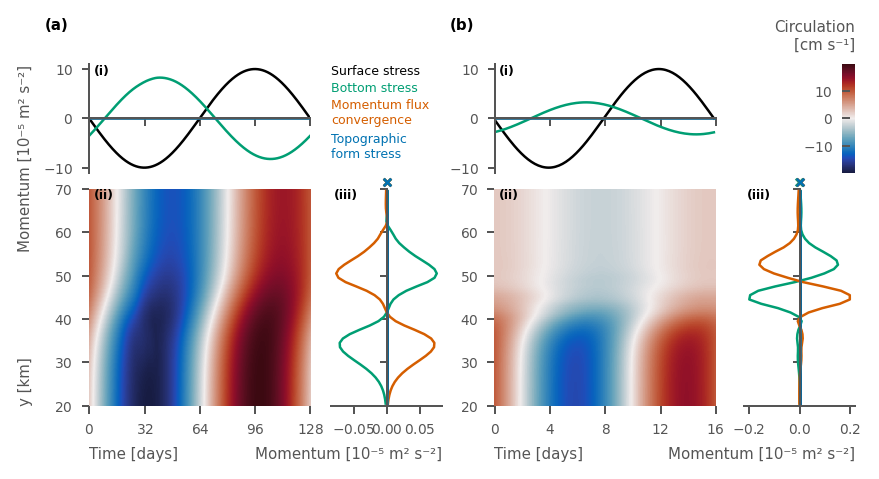

In [34]:
# --- Figure & layout ---------------------------------------------------------
(fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=0.53)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

axd = fig.subplot_mosaic(
    [
        ["ymean_a", "legend_a", "ymean_b", "legend_b"],
        ["circ_a",  "tmean_a",  "circ_b",  "tmean_b"],
    ],
    gridspec_kw=dict(
        height_ratios=[2, 4],
        width_ratios=[4, 2, 4, 2],
    ),
)

# Share axes (avoid redundant ticks/labels)
axd["ymean_a"].sharey(axd["ymean_b"])
for sub in ("a", "b"):
    axd[f"tmean_{sub}"].sharey(axd[f"circ_{sub}"])
    axd[f"ymean_{sub}"].sharex(axd[f"circ_{sub}"])

# Cosmetics & shared tick label suppression
for sub in ("a", "b"):
    customize_axis(axd[f"tmean_{sub}"], yzero=False)
    customize_axis(axd[f"ymean_{sub}"])
    customize_axis(axd[f"legend_{sub}"], yzero=False)
    axd[f"tmean_{sub}"].tick_params(labelleft=False)   # shared y with circ_*
    axd[f"ymean_{sub}"].tick_params(labelbottom=False) # shared x with circ_*
    
    # remove spines, keeping ticks
    axd[f"circ_{sub}"].spines['bottom'].set_visible(False)
    axd[f"circ_{sub}"].spines['left'].set_visible(False)

# Constrained layout padding
fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, wspace=0.02, hspace=0.02)


# --- Data prep & common color scale -----------------------------------------
# Left (long)
tdays_L  = dsYnbcw_L.time / np.timedelta64(1, "D")
Y_L      = ds_L.isel(yC=slice(ystart, ystop)).yC / 1e3

# Right (short) slice & re-zero its own time
tdays_S  = dsYnbcw_S.time / np.timedelta64(1, "D")
Y_S      = ds_S.isel(yC=slice(ystart, ystop)).yC / 1e3

# Unified vlim across panels (so colors are comparable)
vlim = np.nanmax([
    np.abs(dsYnbcw_L.isel(yC=slice(ystart, ystop)).circulation).max(),
    np.abs(dsYnbcw_S.circulation).max(),
])*1e2


# --- LEFT PANEL (LONG) -------------------------------------------------------
# Half-cell padding so ticks at the ends show up with imshow
dt_L = np.diff(tdays_L).mean()
dy_L = np.diff(Y_L).mean()

cm_a = axd["circ_a"].imshow(
    dsYnbcw_L.isel(yC=slice(ystart, ystop)).circulation.T*1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_L[0] - dt_L/2, tdays_L[-1] + dt_L, Y_L[0] - dy_L/2, Y_L[-1] + dy_L/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# Optional for lightweight PDFs
# cm_a.set_rasterized(True)

# Ticks & labels
axd["circ_a"].set_xticks(np.arange(0, 129, 32))
axd["circ_a"].set_yticks(np.arange(20, 71, 10))
axd["circ_a"].set_xlabel("Time [days]", loc="left")
axd["circ_a"].set_ylabel("y [km]", loc="bottom")

# Lines: time-mean (over time) vs Y, and y-mean (over Y) vs time
for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean_L = dsYnbcw_L[term].isel(yC=slice(ystart, ystop)).mean("time") * 1e5
    axd["tmean_a"].plot(tmean_L, Y_L, color=colorwheel[i])

    ymean_L = dsYnbcw_L[term].isel(yC=slice(ystart, ystop)).mean("yC") * 1e5
    axd["ymean_a"].plot(tdays_L, ymean_L, color=colorwheel[i])

    # Marker at y-mean of the time series (placed slightly above the top)
    ytmean_L = ymean_L.mean("time")
    axd["tmean_a"].scatter(ytmean_L, Y_L[-1] + 2, marker="x", color=colorwheel[i], clip_on=False)

    # Collect legend handles in its own axis
    axd["legend_a"].plot([None, None], [None, None], label=term, color=colorwheel[i])

# Legend (left legend axis)
axd["legend_a"].axis("off")
# axd["legend_a"].legend(
#     ["SS", "BS", "MFC", "TFS"],
#     loc="upper left", frameon=False, fontsize=5, bbox_to_anchor=(0, 1.15)
# )
labels = ["Surface stress", "Bottom stress", "Momentum flux\nconvergence", "Topographic\nform stress"]
y_start = 1
line_height = 0.15  # adjust this once
y = y_start
for label, color in zip(labels, colorwheel):
    axd["legend_a"].text(
        0.0, y,
        label,
        color=color,
        fontsize=5,
        transform=axd["legend_a"].transAxes,
        ha="left", va="top"
    )
    n_lines = label.count("\n") + 1
    y -= n_lines * line_height + 0.01  # small gap between entries

# Axes labels for side panels
axd["ymean_a"].set_ylabel("Momentum [10⁻⁵ m² s⁻²]", loc="top")
axd["tmean_a"].set_xlabel("Momentum [10⁻⁵ m² s⁻²]", loc="right")


# --- RIGHT PANEL (SHORT) -----------------------------------------------------
dt_S = np.diff(tdays_S).mean()
dy_S = np.diff(Y_S).mean()

cm_b = axd["circ_b"].imshow(
    dsYnbcw_S.circulation.T*1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_S[0] - dt_S/2, tdays_S[-1] + dt_S, Y_S[0] - dy_S/2, Y_S[-1] + dy_S/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# cm_b.set_rasterized(True)

axd["circ_b"].set_xticks(np.arange(0, 17, 4))
axd["circ_b"].set_yticks(np.arange(20, 71, 10))
axd["circ_b"].set_xlabel("Time [days]", loc="left")

for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean_S = dsYnbcw_S[term].isel(yC=slice(ystart, ystop)).mean("time") * 1e5
    axd["tmean_b"].plot(tmean_S, Y_S, color=colorwheel[i])

    ymean_S = dsYnbcw_S[term].isel(yC=slice(ystart, ystop)).mean("yC") * 1e5
    axd["ymean_b"].plot(tdays_S, ymean_S, color=colorwheel[i])

    ytmean_S = ymean_S.mean("time")
    axd["tmean_b"].scatter(ytmean_S, Y_S[-1] + 2, marker="x", color=colorwheel[i], clip_on=False)

    axd["legend_b"].plot([None, None], [None, None], label=term, color=colorwheel[i])

axd["legend_b"].axis("off")

# Colorbar in legend_b, sharing cm_a normalization
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cax = inset_axes(axd["legend_b"], width="12%", height="100%", loc="center right", borderpad=0.0)
cax.set_in_layout(True)
cbar = plt.colorbar(cm_a, cax=cax, orientation="vertical")
cbar.ax.tick_params(direction="in")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_ticks_position("left")
cax.set_title("Circulation\n[cm s⁻¹]", fontsize=6, loc="right")

# Axes labels for side panels
axd["tmean_b"].set_xlabel("Momentum [10⁻⁵ m² s⁻²]", loc="right")

# Set x-limits to match momentum ranges 
#axd["tmean_a"].set_xlim(-0.5, 0.5) 
#axd["tmean_b"].set_xlim(-0.5, 0.5) 

axd["tmean_a"].set_ylim(ystart, ystop)  # lock tmean ranges to panel height
axd["tmean_b"].set_ylim(ystart, ystop)

# --- Panel annotations --------------------------------------------------------
for sub in ("a", "b"):
    for panel, text in zip(("ymean_", "circ_", "tmean_"), ("(i)", "(ii)", "(iii)")):
        axd[panel + sub].text(
            0.02, 1.00, text, color="black",
            transform=axd[panel + sub].transAxes,
            va="top", fontweight="bold", fontsize=5
        )
    axd["ymean_" + sub].text(
        -0.2, 1.43, f"({sub})", color="black",
        transform=axd["ymean_" + sub].transAxes,
        va="top", fontweight="bold", fontsize=6
    )

# Align any remaining shared labels (once, near the end)
fig.align_labels()

# --- Save --------------------------------------------------------------------
fig.savefig(figpath + "Ymomentum_nobumps_crosswind.pdf")


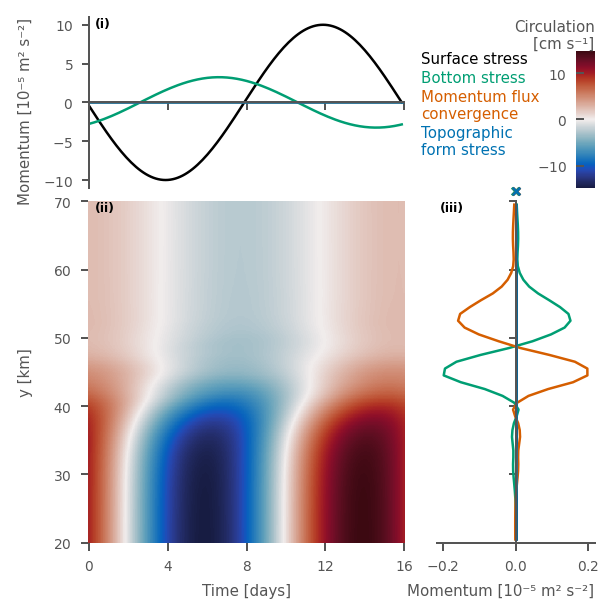

In [35]:
### focus on just one time period
# --- Figure & layout ---------------------------------------------------------
(fig_width_in, fig_height_in), _ = get_figure_dimensions("single", aspect_ratio=1)
fig = plt.figure(layout="constrained", 
                 figsize=(fig_width_in, fig_height_in))

axd = fig.subplot_mosaic(
    [   
        ["ymean", "legend"],
        ["circ",  "tmean"],
    ],
    gridspec_kw=dict(
        height_ratios=[2, 4],
        width_ratios=[4, 2],
    ),
)

# Share axes (avoid redundant ticks/labels)
axd[f"tmean"].sharey(axd[f"circ"])
axd[f"ymean"].sharex(axd[f"circ"])


# Cosmetics & shared tick label suppression
customize_axis(axd[f"tmean"], yzero=False)
customize_axis(axd[f"ymean"])
customize_axis(axd[f"legend"], yzero=False)
axd[f"tmean"].tick_params(labelleft=False)   # shared y with circ_*
axd[f"ymean"].tick_params(labelbottom=False) # shared x with circ_*

# remove spines, keeping ticks
axd[f"circ"].spines['bottom'].set_visible(False)
axd[f"circ"].spines['left'].set_visible(False)

# Constrained layout padding
fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, wspace=0.02, hspace=0.02)


# --- Data prep & common color scale -----------------------------------------
tdays  = dsYnbcw_S.time / np.timedelta64(1, "D")
Y      = ds_S.isel(yC=slice(ystart, ystop)).yC / 1e3

# Unified vlim across panels (so colors are comparable)
vlim = np.nanmax([
    np.abs(dsYnbcw_S.circulation).max(),
])*1e2


# --- -----------------------------------------------------
dt = np.diff(tdays).mean()
dy = np.diff(Y).mean()

cm = axd["circ"].imshow(
    dsYnbcw_S.circulation.T*1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays[0] - dt/2, tdays[-1] + dt, Y[0] - dy/2, Y[-1] + dy/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# cm_b.set_rasterized(True)

for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean_S = dsYnbcw_S[term].isel(yC=slice(ystart, ystop)).mean("time") * 1e5
    axd["tmean"].plot(tmean_S, Y_S, color=colorwheel[i])

    ymean_S = dsYnbcw_S[term].isel(yC=slice(ystart, ystop)).mean("yC") * 1e5
    axd["ymean"].plot(tdays_S, ymean_S, color=colorwheel[i])

    ytmean_S = ymean_S.mean("time")
    axd["tmean"].scatter(ytmean_S, Y_S[-1] + 2, marker="x", color=colorwheel[i], clip_on=False)

    axd["legend"].plot([None, None], [None, None], label=term, color=colorwheel[i])

axd["legend"].axis("off")

cax = inset_axes(axd["legend"], width="12%", height="80%", loc="lower right", borderpad=0.0)
cax.set_in_layout(True)
cbar = plt.colorbar(cm, cax=cax, orientation="vertical")
cbar.ax.tick_params(direction="in")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_ticks_position("left")
cax.set_title("Circulation\n[cm s⁻¹]", fontsize=6, loc="right", pad=-0.15)

labels = ["Surface stress", "Bottom stress", "Momentum flux\nconvergence", "Topographic\nform stress"]
y_start = 0.8
line_height = 0.1  # adjust this once
y = y_start
for label, color in zip(labels, colorwheel):
    axd["legend"].text(
        -0.1, y,
        label,
        color=color,
        fontsize=6,
        transform=axd["legend"].transAxes,
        ha="left", va="top"
    )
    n_lines = label.count("\n") + 1
    y -= n_lines * line_height + 0.01  # small gap between entries

# Axes labels and ranges
axd["circ"].set_xticks(np.arange(0, 17, 4))
axd["circ"].set_yticks(np.arange(20, 71, 10))
axd["circ"].set_xlabel("Time [days]")
axd["circ"].set_ylabel("y [km]")
axd["tmean"].set_xlabel("Momentum [10⁻⁵ m² s⁻²]",loc="right")
axd["ymean"].set_ylabel("Momentum [10⁻⁵ m² s⁻²]", loc="top")

# Set x-limits to match momentum ranges 
#axd["tmean_a"].set_xlim(-0.5, 0.5) 
#axd["tmean_b"].set_xlim(-0.5, 0.5) 
for panel, text in zip(("ymean", "circ", "tmean"), ("(i)", "(ii)", "(iii)")):
        axd[panel].text(
            0.02, 1.00, text, color="black",
            transform=axd[panel].transAxes,
            va="top", fontweight="bold", fontsize=5
        )

axd["tmean"].set_ylim(ystart, ystop)

# Align any remaining shared labels (once, near the end)
fig.align_labels()

# --- Save --------------------------------------------------------------------
fig.savefig(figpath + "Ymomentum_nobumps_crosswind_S.pdf", 
            #bbox_inches="tight", 
            #pad_inches=0.02
            )



## No bumps, regular and cross-slope forcing

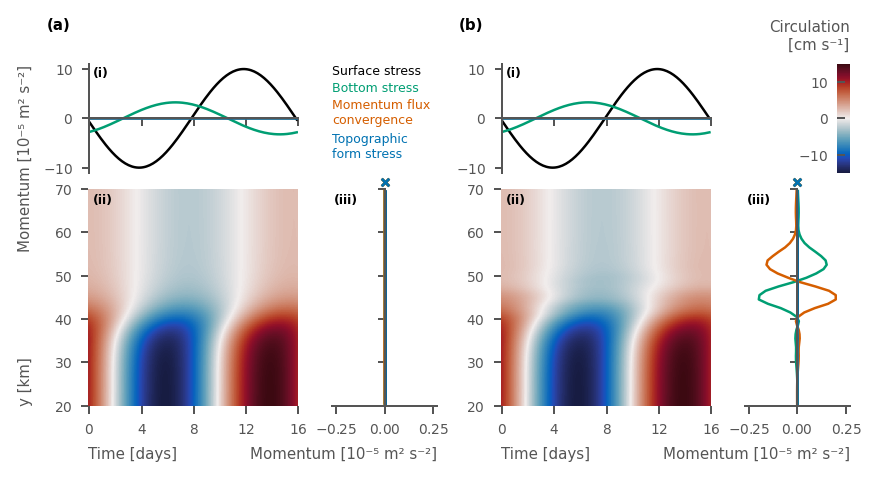

In [36]:
# --- Figure & layout ---------------------------------------------------------
(fig_width_in, fig_height_in), _ = get_figure_dimensions("double", aspect_ratio=0.53)
fig = plt.figure(layout="constrained", figsize=(fig_width_in, fig_height_in))

axd = fig.subplot_mosaic(
    [
        ["ymean_a", "legend_a", "ymean_b", "legend_b"],
        ["circ_a",  "tmean_a",  "circ_b",  "tmean_b"],
    ],
    gridspec_kw=dict(
        height_ratios=[2, 4],
        width_ratios=[4, 2, 4, 2],
    ),
)

# Share axes (avoid redundant ticks/labels)
axd["ymean_a"].sharey(axd["ymean_b"])
for sub in ("a", "b"):
    axd[f"tmean_{sub}"].sharey(axd[f"circ_{sub}"])
    axd[f"ymean_{sub}"].sharex(axd[f"circ_{sub}"])

# Cosmetics & shared tick label suppression
for sub in ("a", "b"):
    customize_axis(axd[f"tmean_{sub}"], yzero=False)
    customize_axis(axd[f"ymean_{sub}"])
    customize_axis(axd[f"legend_{sub}"], yzero=False)
    axd[f"tmean_{sub}"].tick_params(labelleft=False)   # shared y with circ_*
    axd[f"ymean_{sub}"].tick_params(labelbottom=False) # shared x with circ_*
    
    # remove spines, keeping ticks
    axd[f"circ_{sub}"].spines['bottom'].set_visible(False)
    axd[f"circ_{sub}"].spines['left'].set_visible(False)

# Constrained layout padding
fig.set_constrained_layout_pads(w_pad=0.02, h_pad=0.02, wspace=0.02, hspace=0.02)


# --- Data prep & common color scale -----------------------------------------
tdays_S  = dsYnb_S.time / np.timedelta64(1, "D")
Y_S      = ds_S.isel(yC=slice(ystart, ystop)).yC / 1e3

# Unified vlim across panels (so colors are comparable)
vlim = np.nanmax([
    np.abs(dsYnbcw_S.circulation).max(),
    np.abs(dsYnb_S.circulation).max(),
])*1e2


# --- LEFT PANEL (regular) -------------------------------------------------------
# Half-cell padding so ticks at the ends show up with imshow
cm_a = axd["circ_a"].imshow(
    dsYnb_S.circulation.T*1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_S[0] - dt_S/2, tdays_S[-1] + dt_S, Y_S[0] - dy_S/2, Y_S[-1] + dy_S/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# Optional for lightweight PDFs
# cm_a.set_rasterized(True)

# Ticks & labels
axd["circ_a"].set_xticks(np.arange(0, 17, 4))
axd["circ_a"].set_yticks(np.arange(20, 71, 10))
axd["circ_a"].set_xlabel("Time [days]", loc="left")
axd["circ_a"].set_ylabel("y [km]", loc="bottom")

# Lines: time-mean (over time) vs Y, and y-mean (over Y) vs time
for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean_S = dsYnb_S[term].isel(yC=slice(ystart, ystop)).mean("time") * 1e5
    axd["tmean_a"].plot(tmean_S, Y_S, color=colorwheel[i])

    ymean_S = dsYnb_S[term].isel(yC=slice(ystart, ystop)).mean("yC") * 1e5
    axd["ymean_a"].plot(tdays_S, ymean_S, color=colorwheel[i])

    # Marker at y-mean of the time series (placed slightly above the top)
    ytmean_S = ymean_S.mean("time")
    axd["tmean_a"].scatter(ytmean_S, Y_S[-1] + 2, marker="x", color=colorwheel[i], clip_on=False)

    # Collect legend handles in its own axis
    axd["legend_a"].plot([None, None], [None, None], label=term, color=colorwheel[i])

# Legend (left legend axis)
axd["legend_a"].axis("off")
# axd["legend_a"].legend(
#     ["SS", "BS", "MFC", "TFS"],
#     loc="upper left", frameon=False, fontsize=5, bbox_to_anchor=(0, 1.15)
# )
labels = ["Surface stress", "Bottom stress", "Momentum flux\nconvergence", "Topographic\nform stress"]
y_start = 1
line_height = 0.15  # adjust this once
y = y_start
for label, color in zip(labels, colorwheel):
    axd["legend_a"].text(
        0.0, y,
        label,
        color=color,
        fontsize=5,
        transform=axd["legend_a"].transAxes,
        ha="left", va="top"
    )
    n_lines = label.count("\n") + 1
    y -= n_lines * line_height + 0.01  # small gap between entries

# Axes labels for side panels
axd["ymean_a"].set_ylabel("Momentum [10⁻⁵ m² s⁻²]", loc="top")
axd["tmean_a"].set_xlabel("Momentum [10⁻⁵ m² s⁻²]", loc="right")


# --- RIGHT PANEL (cross-slope) -----------------------------------------------------
cm_b = axd["circ_b"].imshow(
    dsYnbcw_S.circulation.T*1e2,
    origin="lower",
    aspect="auto",
    extent=[tdays_S[0] - dt_S/2, tdays_S[-1] + dt_S, Y_S[0] - dy_S/2, Y_S[-1] + dy_S/2],
    vmin=-vlim, vmax=vlim, cmap=palette["cmdiv"],
)
# cm_b.set_rasterized(True)

axd["circ_b"].set_xticks(np.arange(0, 17, 4))
axd["circ_b"].set_yticks(np.arange(20, 71, 10))
axd["circ_b"].set_xlabel("Time [days]", loc="left")

for i, term in enumerate(["SS", "BS", "MFC", "TFS"]):
    tmean_S = dsYnbcw_S[term].isel(yC=slice(ystart, ystop)).mean("time") * 1e5
    axd["tmean_b"].plot(tmean_S, Y_S, color=colorwheel[i])

    ymean_S = dsYnbcw_S[term].isel(yC=slice(ystart, ystop)).mean("yC") * 1e5
    axd["ymean_b"].plot(tdays_S, ymean_S, color=colorwheel[i])

    ytmean_S = ymean_S.mean("time")
    axd["tmean_b"].scatter(ytmean_S, Y_S[-1] + 2, marker="x", color=colorwheel[i], clip_on=False)

    axd["legend_b"].plot([None, None], [None, None], label=term, color=colorwheel[i])

axd["legend_b"].axis("off")

# Colorbar in legend_b, sharing cm_a normalization
# from mpl_toolkits.axes_grid1.inset_locator import inset_axes
cax = inset_axes(axd["legend_b"], width="12%", height="100%", loc="center right", borderpad=0.0)
cbar = plt.colorbar(cm_a, cax=cax, orientation="vertical")
cbar.ax.tick_params(direction="in")
cbar.outline.set_visible(False)
cbar.ax.yaxis.set_ticks_position("left")
cax.set_title("Circulation\n[cm s⁻¹]", fontsize=6, loc="right")

# Axes labels for side panels
axd["tmean_b"].set_xlabel("Momentum [10⁻⁵ m² s⁻²]", loc="right")

# Set x-limits to match momentum ranges 
axd["tmean_a"].set_xlim(-0.27, 0.27) 
axd["tmean_b"].set_xlim(-0.27, 0.27) 

axd["tmean_a"].set_ylim(ystart, ystop)  # lock tmean ranges to panel height
axd["tmean_b"].set_ylim(ystart, ystop)

# --- Panel annotations --------------------------------------------------------
for sub in ("a", "b"):
    for panel, text in zip(("ymean_", "circ_", "tmean_"), ("(i)", "(ii)", "(iii)")):
        axd[panel + sub].text(
            0.02, 0.98, text, color="black",
            transform=axd[panel + sub].transAxes,
            va="top", fontweight="bold", fontsize=5
        )
    axd["ymean_" + sub].text(
        -0.2, 1.43, f"({sub})", color="black",
        transform=axd["ymean_" + sub].transAxes,
        va="top", fontweight="bold", fontsize=6
    )

# Align any remaining shared labels (once, near the end)
fig.align_labels()

# --- Save --------------------------------------------------------------------
fig.savefig(figpath + "Ymomentums_nobumps.pdf")


## Topographic wave properties

### Arrest speed

In [37]:
def estimate_prograde_retrograde_speed(dsH,selection=slice(40,50), spread=True):
    slope = dsH.sel(j=selection).circulation
    #slope = dsH.sel(j=slice(40,50)).circulation    
    
    if spread:
        prograde = slope.max("time").mean("j").item()
        retrograde = np.abs(slope.min("time").mean("j").item())
        
        retrograde_max = np.abs(slope.min("time").min("j").item())
        retrograde_min = np.abs(slope.min("time").max("j").item())
    
    
        return retrograde, prograde, retrograde_min, retrograde_max

    else:
        retrograde = np.abs(np.min(slope))
        prograde = np.max(slope)
        
        return retrograde, prograde

In [38]:
params_22km = load_config("../configs/varying_bathymetry/half.json")
params_90km = load_config("../configs/varying_bathymetry/double.json")

if load_preprocessed:
    dsH_22km = xr.open_dataset("../output/processed/varying_bathymetry/dsH_22km.nc")
    dsH_90km = xr.open_dataset("../output/processed/varying_bathymetry/dsH_90km.nc")    
    
else: 
    # read simulation output
    ds_22km = read_raw_output(params_22km)
    ds_90km = read_raw_output(params_90km)

    # interpolate dataset onto the selected depth-contours
    dsH_22km = prepare_dsH(ds_22km, params_22km, H_targets)
    dsH_90km = prepare_dsH(ds_90km, params_90km, H_targets)
    
    if save_processed:
        os.makedirs("../output/processed/varying_bathymetry/", exist_ok=True)
        dsH_22km.to_netcdf("../output/processed/varying_bathymetry/dsH_22km.nc")
        dsH_90km.to_netcdf("../output/processed/varying_bathymetry/dsH_90km.nc")

for dsH, params in zip([dsH_22km, dsH_90km], [params_22km, params_90km]):
    # diagnose circulation
    dsH["circulation"] = mean_onH(dsH, variable="ui")

Loading configuration from ../configs/varying_bathymetry/half.json
Loading configuration from ../configs/varying_bathymetry/double.json


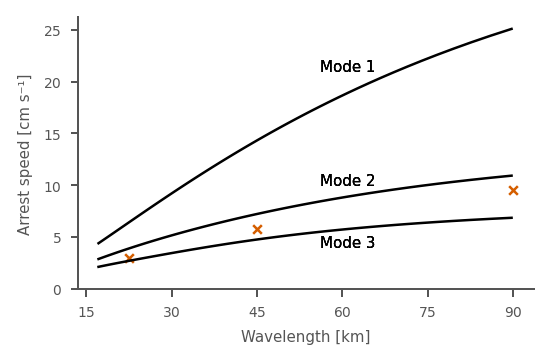

In [39]:
import scipy.io

fig, ax = create_figure("single",
                        #aspect_ratio=0.75
                               )
customize_axis(ax, xzero=False)

for mode, color in zip([1, 2, 3], ["black", "black", "black"]):
    bwaves_data = scipy.io.loadmat(f"../output/raw/bwavesp_raw_outputs_mode{mode}_full.mat")
    rl = bwaves_data["rl"].flatten()  # wavenumber [rad/cm]
    ws = bwaves_data["ws"].flatten()  # frequency [rad/s]

    k = rl / 0.01                         # rad/cm → rad/m
    lambda_km = 2 * np.pi / k / 1000      # wavelength [km]
    c_phase_cmps = (ws / k) * 100

    ax.plot(lambda_km, c_phase_cmps, color=color)

#ax.set_xlim(0,None)
ax.set_ylim(0,None)
ax.set_xticks([15, 30, 45, 60, 75, 90])


ax.set_xlabel("Wavelength [km]")
ax.set_ylabel("Arrest speed [cm s⁻¹]")

for dsH, wl in zip([dsH_22km, dsH_L, dsH_90km], [22.5, 45, 90]):
    retrograde, prograde, retrograde_min, retrograde_max = estimate_prograde_retrograde_speed(dsH)
    ax.scatter(wl, retrograde*1e2, color=colorwheel[2], marker="x", s=12)
    # lower = (retrograde - retrograde_min) * 1e2
    # upper = (retrograde_max - retrograde) * 1e2
    # ax.errorbar(wl, retrograde*1e2, yerr=[[lower], [upper]],
    #             color=colorwheel[2], 
    #             #marker="x", 
    #             capsize=4)
    
    # add text with mode number
    ax.text(56, 21, "Mode 1", color="black")
    ax.text(56, 10, "Mode 2", color="black")
    ax.text(56, 4, "Mode 3", color="black")
    
fig.savefig(figpath+"arrest_speed.pdf", bbox_inches="tight", pad_inches=0.02)

fig.patch.set_alpha(0.0)     # figure background
ax.patch.set_alpha(0.0)      # axes background (optional)
fig.savefig(figpath+"arrest_speed_pres.svg", bbox_inches="tight", pad_inches=0.02, transparent=True)

### Mode structure

In [40]:
# Load MATLAB file
bwaves_data = scipy.io.loadmat("../output/raw/bwavesp_raw_outputs_mode2_45km.mat")
x = bwaves_data["x"].flatten()
pp = bwaves_data["pp"].flatten()

In [41]:
eta = dsY_L["h"] - dsY_L["bath"]
etanod = eta - eta.mean(dim="xC")

etanod_neg = etanod.isel(time=slice(0,64*8))
etanod_pos = etanod.isel(time=slice(64*8,None))
etanod_pos["time"] = etanod_pos["time"] - etanod_pos["time"].isel(time=0)

mode = etanod_neg + etanod_pos 

In [42]:
# params_reduced = load_config("../configs/baseline_forcing/long_reduced_bumps.json")
# ds_reduced = read_raw_output(params_reduced)


# dsY_reduced = interp_ds(ds_S, params_S, ["u", "v", "forcing_x", "detadx", "duvhdy"])
# dsY_reduced = dsY_reduced.isel(time=slice(focus_time_start_L,focus_time_stop_L))
# dsY_reduced["time"] = dsY_reduced.time - dsY_reduced.time.isel(time=0)

# eta = dsY_reduced["h"] - dsY_reduced["bath"]
# etanod = eta - eta.mean(dim="xC")

# etanod_neg = etanod.isel(time=slice(0,64*8))
# etanod_pos = etanod.isel(time=slice(64*8,None))
# etanod_pos["time"] = etanod_pos["time"] - etanod_pos["time"].isel(time=0)

# mode = etanod_neg + etanod_pos 

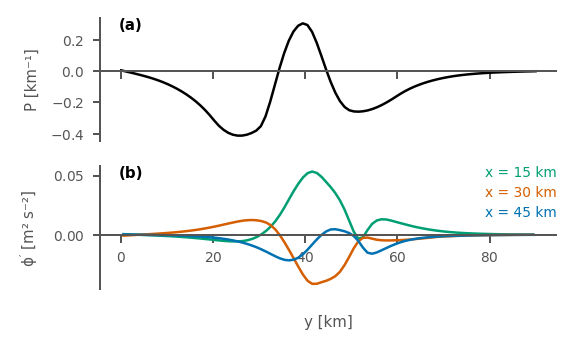

In [43]:
tidx = 30*8

fig, [axt,axb] = create_figure("single", 
                               nrows=2, 
                               sharex =True
                               )

customize_axis(axt, xzero=False)
customize_axis(axb, xzero=False)

ys = mode.yC/1e3

axt.plot(x/1e5, pp*1e5, color="black")  # pp has units cm-1, wan to konvert to units of km-1

for i, xidx in enumerate([15,30,45]):
    modei = mode.isel(time=tidx, xC=xidx)*9.81  # convert to dynamic pressure
    axb.plot(ys, modei, color=colorwheel[i+1], label=f"x = {xidx} km")
    
#axb.legend(loc="upper right", frameon=False, bbox_to_anchor=(1,1.4))
labels = ["x = 15 km", "x = 30 km", "x = 45 km"]
y_start = 1
line_height = 0.15  # adjust this once
y = y_start
for label, color in zip(labels, colorwheel[1:]):
    axb.text(
        1, y,
        label,
        color=color,
        fontsize=5.5,
        transform=axb.transAxes,
        ha="right", va="top"
    )
    n_lines = label.count("\n") + 1
    y -= n_lines * line_height + 0.01  # small gap between entries

axb.set_xlabel("y [km]", labelpad=20)

axt.set_ylabel("P [km⁻¹]")  # this is a normalized pressure structure function
axb.set_ylabel(r"$\phi'$ [m² s⁻²]")

# # Shift x-axis tick labels downward
# for label in axb.get_xticklabels():
#     label.set_y(label.get_position()[1] - 17e-4)
fig.align_labels()


axt.text(0.04, 1, "(a)", color="black",
         transform=axt.transAxes,
         va="top", fontweight="bold", fontsize=6)
axb.text(0.04, 1, "(b)", color="black",
         transform=axb.transAxes,
         va="top", fontweight="bold", fontsize=6)


fig.savefig(figpath+"mode_structure.pdf", bbox_inches="tight", pad_inches=0.02)


In [44]:
np.mean(np.abs(pp*1e5))*90

13.036863167670802

In [45]:
# tidx = 30*8

# fig, [axt,axb] = create_figure("single", 
#                                nrows=2, 
#                                sharex =True
#                                )

# customize_axis(axt, xzero=False)
# customize_axis(axb, xzero=False)

# ys = mode.yC/1e3

# axt.plot(x/1e5, pp, color="black")


# modei = mode.isel(time=tidx, xC=45)*9.81  # convert to dynamic pressure
# axb.plot(ys, modei, color="#e300e3")


# axb.set_xlabel("y [km]", labelpad=20)

# axt.set_ylabel("P [cm⁻¹]")  # this is a normalized pressure structure function
# axb.set_ylabel(r"$\phi'$ [m² s⁻²]")

# # # Shift x-axis tick labels downward
# # for label in axb.get_xticklabels():
# #     label.set_y(label.get_position()[1] - 17e-4)
# fig.align_labels()

# # Make the figure background transparent
# fig.patch.set_alpha(0.0)     # figure background
# axt.patch.set_alpha(0.0)      # axes background (optional)
# axb.patch.set_alpha(0.0) 
# fig.savefig(figpath+"mode_structure_pres.svg", bbox_inches="tight", pad_inches=0.02, transparent=True)


### Max speed as function of forcing strength

In [46]:
def hanning_filter(da, window_length = 6*8):
    # following http://xarray.pydata.org/en/stable/computation.html#rolling-window-operations
    hamming = np.hanning(window_length)
    window = xr.DataArray(hamming/np.sum(hamming), dims=['window'])
    rolling = da.rolling(time=window_length, center=True)
    filtered = rolling.construct(time='window').dot(window)

    
    return filtered    

In [47]:
depths_to_use = [H_targets[40], H_targets[45], H_targets[50]]
periods = ["short", "long"]
n_runs = 8 

# --- Pre-allocate tidy dataset ---
ds_out = xr.Dataset(
    coords=dict(
        period=("period", periods),
        run=("run", np.arange(1, n_runs + 1)),
        depth=("depth", depths_to_use),
    ),
    data_vars=dict(
        forcing_strength=(("period", "run"), np.full((len(periods), n_runs), np.nan)),
        prograde_max=(("period", "depth", "run"), np.full((len(periods), len(depths_to_use), n_runs), np.nan)),
        retrograde_max=(("period", "depth", "run"), np.full((len(periods), len(depths_to_use), n_runs), np.nan)),
    ),
)

if not load_preprocessed:
    # --- Main loop ---
    for p_idx, p in enumerate(periods):
        for r in range(1, n_runs + 1):
            params_i = load_config(f"../configs/varying_forcing/{p}_{r:03d}.json")
            forcing = params_i["tau0"]
            ds_i = read_raw_output(params_i).isel(time=slice(-128*8, None))

            dsH_i = prepare_dsH(ds_i, params_i, depths_to_use)
            circ = mean_onH(dsH_i, variable="ui")
            dsH_i["circulation"] = hanning_filter(circ, window_length=2*8)

            ds_out["forcing_strength"][p_idx, r - 1] = forcing

            for k, H in enumerate(dsH_i["depth"].values):
                retro, pro = estimate_prograde_retrograde_speed(dsH_i, selection=k, spread=False)
                ds_out["prograde_max"][p_idx, k, r - 1] = pro
                ds_out["retrograde_max"][p_idx, k, r - 1] = retro

    # --- Save only if requested ---
    if save_processed:
        # This will independently sort runs for each period. 
        ds_sorted = ds_out.copy() 
        for p in periods: 
            F = ds_out["forcing_strength"].sel(period=p) 
            order = np.argsort(F.values) 
            ds_sorted["forcing_strength"].loc[dict(period=p)] = F.values[order] 
            for var in ["prograde_max", "retrograde_max"]: 
                ds_sorted[var].loc[dict(period=p)] = ds_out[var].sel(period=p).values[..., order]
                
        vars_to_save = ["forcing_strength", "prograde_max", "retrograde_max"]
        ds_to_write = ds_sorted[vars_to_save]
        encoding = {v: {"zlib": True, "complevel": 4, "dtype": "f4"} for v in vars_to_save}

        os.makedirs("../output/processed/varying_forcing/", exist_ok=True)
        outpath = "../output/processed/varying_forcing/summary.nc"
        ds_to_write.to_netcdf(outpath, encoding=encoding)
        print(f"Saved sorted dataset to {outpath}")
else:
    # --- Load preprocessed data if available ---
    ds_sorted = xr.open_dataset("../output/processed/varying_forcing/summary.nc")
    print("Loaded preprocessed dataset.")


Loaded preprocessed dataset.


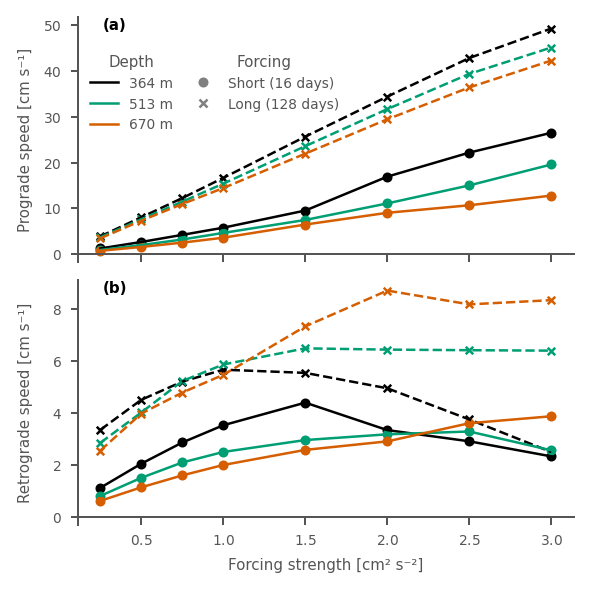

In [ ]:


#fig, (ax1, ax2) = plt.subplots(2, 1, figsize=get_figure_dimensions(aspect_ratio=1), sharex=True)
fig, [ax1,ax2] = create_figure("single", 
                               aspect_ratio=1,
                               nrows=2, 
                               sharex =True
                               )
customize_axis(ax1, xzero=False)
customize_axis(ax2, xzero=False)

depths = list(ds_sorted.depth.values)

# --- Plotting ---
for i, depth in enumerate(depths):
    c = colorwheel[i]

    # Prograde
    x_short = ds_sorted.forcing_strength.sel(period="short")*1e4
    y_short = ds_sorted.prograde_max.sel(period="short", depth=depth)*1e2
    ax1.plot(x_short, y_short, color=c)
    ax1.scatter(x_short, y_short, color=c, marker="o")

    x_long = ds_sorted.forcing_strength.sel(period="long")*1e4
    y_long = ds_sorted.prograde_max.sel(period="long", depth=depth)*1e2
    ax1.plot(x_long, y_long, color=c, ls="--")
    ax1.scatter(x_long, y_long, color=c, marker="x")

    # Retrograde
    y_short = ds_sorted.retrograde_max.sel(period="short", depth=depth)*1e2
    ax2.plot(x_short, y_short, color=c)
    ax2.scatter(x_short, y_short, color=c, marker="o")

    y_long = ds_sorted.retrograde_max.sel(period="long", depth=depth)*1e2
    ax2.plot(x_long, y_long, color=c, ls="--")
    ax2.scatter(x_long, y_long, color=c, marker="x")

# --- Legends ---
# Depth legend (colors only)
depth_handles = [
    Line2D([0], [0], color=colorwheel[i], label=f"{int(d)} m")
    for i, d in enumerate(depths)
]

# Forcing legend (symbols only, in grey)
forcing_handles = [
    Line2D([0], [0], marker="o", color="grey", linestyle="None", label="Short (16 days)"),
    Line2D([0], [0], marker="x", color="grey", linestyle="None", label="Long (128 days)"),
]

leg_depths = ax1.legend(handles=depth_handles, title="Depth", 
                        frameon=False, loc="upper left" , bbox_to_anchor=(0, 0.9))
leg_forcing = ax1.legend(handles=forcing_handles, title="Forcing",
                         frameon=False, loc="upper left", bbox_to_anchor=(0.2, 0.9))
ax1.add_artist(leg_depths)

# Labels
ax1.set_ylabel("Prograde speed [cm s⁻¹]")
ax2.set_ylabel("Retrograde speed [cm s⁻¹]")
ax2.set_xlabel("Forcing strength [cm² s⁻²]")

ax2.set_ylim(-0.3, None)

ax1.text(0.05, 1, "(a)", color="black",
         transform=ax1.transAxes,
         va="top", fontweight="bold", fontsize=6)
ax2.text(0.05, 1, "(b)", color="black",
         transform=ax2.transAxes,
         va="top", fontweight="bold", fontsize=6)

fig.align_labels()
fig.tight_layout()
fig.savefig(figpath+"increasing_forcing.pdf", bbox_inches="tight")